In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [10]:
import numpy as np
np.load('/home/saihan/New folder/data/anger/anger_1.npy')

array([[-1.0000000e+03, -1.0000000e+03, -1.0000000e+03, ...,
        -1.0000000e+03, -1.0000000e+03, -1.0000000e+03],
       [-1.0000000e+03, -1.0000000e+03, -1.0000000e+03, ...,
        -1.0000000e+03, -1.0000000e+03, -1.0000000e+03],
       [-1.0000000e+03, -1.0000000e+03, -1.0000000e+03, ...,
        -1.0000000e+03, -1.0000000e+03, -1.0000000e+03],
       ...,
       [ 4.8828124e-08, -1.7480468e-05,  6.8847653e-06, ...,
         1.0644531e-05,  1.9482421e-05,  8.1054686e-06],
       [ 1.5624999e-05, -1.7041015e-05,  2.8662109e-05, ...,
        -9.4238276e-06, -2.4609375e-05,  3.3203123e-05],
       [ 1.7578125e-06,  8.3007808e-06,  1.8798828e-05, ...,
        -2.7343749e-06, -4.2187497e-05,  3.2128904e-05]], dtype=float32)

In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
DATA_ROOT = "/home/saihan/New folder/data"
FILES_PER_EMOTION = 10
SEGMENT_LENGTH = 256
EMBEDDING_DIM = 512
BATCH_SIZE = 32
EPOCHS = 100
NUM_FEATURES = 8

def load_emotion_data(data_root, files_per_emotion):
    data, labels, emotion_names = [], [], []
    emotion_dirs = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))])

    for idx, emotion in enumerate(emotion_dirs):
        emotion_path = os.path.join(data_root, emotion)
        emotion_data = []

        for i in range(1, files_per_emotion + 1):
            file_path = os.path.join(emotion_path, f"{emotion}_{i}.npy")
            if os.path.exists(file_path):
                try:
                    emg = np.load(file_path)
                    if emg.shape[1] == NUM_FEATURES:
                        emotion_data.append(emg)
                except Exception as e:
                    print(f"Error loading {file_path}: {e}")
            else:
                print(f"File not found: {file_path}")
        
        if emotion_data:
            data.extend(emotion_data)
            labels.extend([idx] * len(emotion_data))
            emotion_names.append(emotion)
    return data, labels, emotion_names

def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []

    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments > 0:
            reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, NUM_FEATURES)
            segments.append(reshaped)
            segment_labels.extend([label] * n_segments)

    segments = np.concatenate(segments)
    return segments, np.array(segment_labels)

def create_cnn_encoder(segment_length, num_features, embedding_dim):
    input_layer = Input(shape=(segment_length, num_features))
    x = Conv1D(64, 5, activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(128, 5, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(256, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(512, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    embedding = Dense(embedding_dim, activation='relu', name='segment_embedding')(x)
    return Model(inputs=input_layer, outputs=embedding)

def create_classification_model(encoder, num_classes):
    x = encoder.output
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=encoder.input, outputs=output)

def train_model(model, X_train, y_train, X_val, y_val):
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7)
    ]
    return model.fit(X_train, y_train, validation_data=(X_val, y_val),
                     epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1)

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def main():
    print("Loading data...")
    data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION)
    if not data_list:
        print("No data found!")
        return

    print("Preprocessing data...")
    segments, segment_labels = preprocess_data(data_list, labels, SEGMENT_LENGTH)

    print("Normalizing...")
    reshaped = segments.reshape(-1, NUM_FEATURES)
    scaled = StandardScaler().fit_transform(reshaped)
    segments = scaled.reshape(segments.shape)

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

    print("Building model...")
    encoder = create_cnn_encoder(SEGMENT_LENGTH, NUM_FEATURES, EMBEDDING_DIM)
    model = create_classification_model(encoder, num_classes=len(emotion_names))

    print("Training model...")
    history = train_model(model, X_train, y_train, X_val, y_val)

    print("Evaluating model...")
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=emotion_names))
    plot_confusion_matrix(y_test, y_pred, emotion_names)
    plot_training_history(history)

if __name__ == "__main__":
    main()


2025-06-29 11:30:34.027389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751193034.121551    2373 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751193034.148496    2373 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751193034.360698    2373 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751193034.360750    2373 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751193034.360752    2373 computation_placer.cc:177] computation placer alr

Loading data...
Preprocessing data...
Normalizing...
Splitting data...
Building model...


I0000 00:00:1751193042.185359    2373 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-06-29 11:30:42.532710: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  ipykernel_launcher.runfiles/cuda_nvcc
  ipykern/cuda_nvcc
  
  /usr/local/cuda
  /opt/cuda
  /home/saihan/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/saihan/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  /home/saihan/miniconda3/lib/python3.12/site-packages/tensorflow/python/platform/../../c

Training model...
Epoch 1/100


I0000 00:00:1751193047.129574    2543 service.cc:152] XLA service 0x7ff04001a4a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751193047.129605    2543 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-06-29 11:30:47.217883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1751193047.670203    2543 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1751193047.949360    2543 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but s

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/saihan/miniconda3/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/home/saihan/miniconda3/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/home/saihan/miniconda3/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3098, in run_cell

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3153, in _run_cell

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3362, in run_cell_async

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3607, in run_ast_nodes

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3667, in run_code

  File "/tmp/ipykernel_2373/157200975.py", line 166, in <module>

  File "/tmp/ipykernel_2373/157200975.py", line 157, in main

  File "/tmp/ipykernel_2373/157200975.py", line 105, in train_model

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/home/saihan/miniconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_5684]

In [4]:
pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install tensorflow

  Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.1.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.1
    Uninstalling numpy-2.3.1:
      Successfully uninstalled numpy-2.3.1


In [2]:
pip install keras-tcn

Note: you may need to restart the kernel to use updated packages.


VERSION 2.1

2025-07-01 00:13:11.750323: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-01 00:13:13.737283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.16.1
GPU available: []
CUDA_VISIBLE_DEVICES: Not set
Loading data...


2025-07-01 00:13:26.113525: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-01 00:13:26.132128: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loaded 120 files, 12 emotions: ['anger', 'anxiety', 'contempt', 'delight', 'disgust', 'fear', 'happiness', 'neutral', 'perplexity', 'pride', 'sadness', 'surprise']
Preprocessing data...
Preprocessed 21000 segments with shape (21000, 256, 8)
Splitting data...
Train: 13440, Val: 3360, Test: 4200
Building TCN model...
Training TCN model...
Epoch 1/20
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.0814 - loss: 2.4920 - val_accuracy: 0.0833 - val_loss: 2.4850 - learning_rate: 0.0010
Epoch 2/20
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0840 - loss: 2.4851 - val_accuracy: 0.0833 - val_loss: 2.4849 - learning_rate: 0.0010
Epoch 3/20
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0833 - loss: 2.4860 - val_accuracy: 0.0833 - val_loss: 2.4850 - learning_rate: 0.0010
Epoch 4/20
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.0796 - loss: 2.4850 - val_accuracy: 0.0833 - val_loss: 2.4850 - learning_rate: 0.0010
Epoch 5/20
1680/1680 ━━━━━━━━━━━━━━━━━━━━ 6s

/home/saihan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/saihan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/saihan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

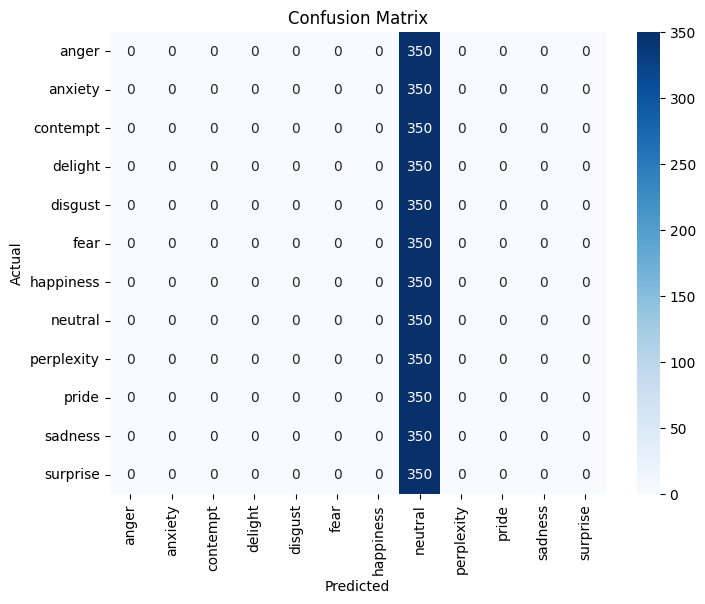

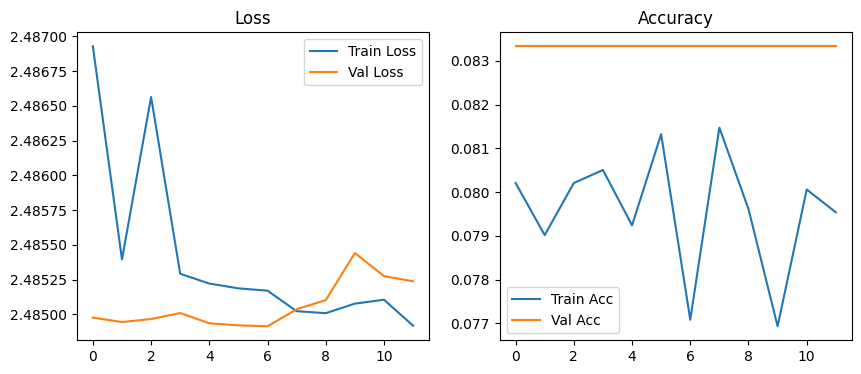

Generating TCN embeddings...
420/420 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Loading LLM...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Preparing LLM inputs...
Fine-tuning LLM...
LLM fine-tuning failed: Could not interpret optimizer identifier: <keras.src.optimizers.adam.Adam object at 0x7fd34fd8fe90>


In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tcn import TCN
from transformers import T5Tokenizer, TFT5ForConditionalGeneration

# --- Configuration ---
DATA_ROOT = "/home/saihan/New folder/data"
FILES_PER_EMOTION = 10
SEGMENT_LENGTH = 256
EMBEDDING_DIM = 128  # Further reduced for RTX 3050
BATCH_SIZE = 8  # Reduced to avoid OOM
EPOCHS = 20  # Reduced for faster testing
NUM_FEATURES = 8
LLM_MODEL = "t5-small"

# --- Data Loading ---
def load_emotion_data(data_root, files_per_emotion):
    data, labels, emotion_names = [], [], []
    emotion_dirs = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))])
    
    for idx, emotion in enumerate(emotion_dirs):
        emotion_path = os.path.join(data_root, emotion)
        emotion_data = []
        for i in range(1, files_per_emotion + 1):
            file_path = os.path.join(emotion_path, f"{emotion}_{i}.npy")
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            try:
                emg = np.load(file_path)
                if emg.shape[1] == NUM_FEATURES and emg.shape[0] >= SEGMENT_LENGTH:
                    emotion_data.append(emg)
                else:
                    print(f"Invalid shape or length in {file_path}: {emg.shape}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if emotion_data:
            data.extend(emotion_data)
            labels.extend([idx] * len(emotion_data))
            emotion_names.append(emotion)
        else:
            print(f"No valid data for emotion: {emotion}")
    
    if not data:
        raise ValueError("No valid data loaded!")
    return data, labels, emotion_names

# --- Data Preprocessing ---
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            print(f"Skipping sample with length {data.shape[0]} < {segment_length}")
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, NUM_FEATURES)
        segments.append(reshaped)
        segment_labels.extend([label] * n_segments)
    
    if not segments:
        raise ValueError("No segments created!")
    
    segments = np.concatenate(segments)
    scaler = StandardScaler()
    reshaped = segments.reshape(-1, NUM_FEATURES)
    scaled = scaler.fit_transform(reshaped)
    segments = scaled.reshape(segments.shape)
    print(f"Preprocessed {segments.shape[0]} segments with shape {segments.shape}")
    return segments, np.array(segment_labels), scaler

# --- TCN Model ---
def create_tcn_encoder(segment_length, num_features, embedding_dim):
    inputs = Input(shape=(segment_length, num_features))
    x = TCN(nb_filters=8, kernel_size=3, dilations=[1], 
            padding='causal', dropout_rate=0.1, return_sequences=False)(inputs)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    embedding = Dense(embedding_dim, activation='relu', name='segment_embedding')(x)
    return Model(inputs=inputs, outputs=embedding)

# --- Classification Model ---
def create_classification_model(encoder, num_classes):
    x = encoder.output
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=encoder.input, outputs=output)

# --- LLM Integration ---
def create_llm_model(model_name=LLM_MODEL):
    try:
        tokenizer = T5Tokenizer.from_pretrained(model_name)
        model = TFT5ForConditionalGeneration.from_pretrained(model_name)
        return tokenizer, model
    except Exception as e:
        print(f"Error loading LLM: {e}")
        raise

def prepare_llm_input(embeddings, labels, emotion_names, tokenizer, max_length=50):
    prompts, text_labels = [], []
    for emb, label in zip(embeddings, labels):
        prompt = f"EMG features: {emb.tolist()[:8]}... Describe the emotion."
        prompts.append(prompt)
        text_labels.append(f"The user is experiencing {emotion_names[label]}.")
    
    inputs = tokenizer(prompts, max_length=max_length, padding=True, truncation=True, return_tensors="tf")
    outputs = tokenizer(text_labels, max_length=max_length, padding=True, truncation=True, return_tensors="tf")
    return inputs, outputs

# --- Training ---
def train_tcn_model(model, X_train, y_train, X_val, y_val):
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    ]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1)
    return history

def fine_tune_llm(model, tokenizer, inputs, outputs, epochs=1):
    model.compile(optimizer=Adam(1e-5), loss=model.compute_loss)
    model.fit(inputs, outputs, epochs=epochs, batch_size=BATCH_SIZE, verbose=1)

# --- Visualization ---
def plot_training_history(history):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# --- Main Function ---
def main():
    print("TensorFlow version:", tf.__version__)
    print("GPU available:", tf.config.list_physical_devices('GPU'))
    print("CUDA_VISIBLE_DEVICES:", os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set'))

    print("Loading data...")
    try:
        data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION)
        print(f"Loaded {len(data_list)} files, {len(emotion_names)} emotions: {emotion_names}")
    except ValueError as e:
        print(f"Data loading failed: {e}")
        return

    print("Preprocessing data...")
    try:
        segments, segment_labels, scaler = preprocess_data(data_list, labels, SEGMENT_LENGTH)
    except ValueError as e:
        print(f"Preprocessing failed: {e}")
        return

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

    print("Building TCN model...")
    tcn_encoder = create_tcn_encoder(SEGMENT_LENGTH, NUM_FEATURES, EMBEDDING_DIM)
    tcn_model = create_classification_model(tcn_encoder, num_classes=len(emotion_names))
    
    print("Training TCN model...")
    try:
        history = train_tcn_model(tcn_model, X_train, y_train, X_val, y_val)
    except Exception as e:
        print(f"TCN training failed: {e}")
        return

    print("Evaluating TCN model...")
    y_pred = np.argmax(tcn_model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=emotion_names))
    plot_confusion_matrix(y_test, y_pred, emotion_names)
    plot_training_history(history)

    print("Generating TCN embeddings...")
    embeddings = tcn_encoder.predict(X_train)

    print("Loading LLM...")
    try:
        tokenizer, llm_model = create_llm_model()
    except Exception as e:
        print(f"LLM loading failed: {e}")
        return

    print("Preparing LLM inputs...")
    llm_inputs, llm_outputs = prepare_llm_input(embeddings, y_train, emotion_names, tokenizer)

    print("Fine-tuning LLM...")
    try:
        fine_tune_llm(llm_model, tokenizer, llm_inputs, llm_outputs)
    except Exception as e:
        print(f"LLM fine-tuning failed: {e}")
        return

    print("Testing LLM...")
    test_embeddings = tcn_encoder.predict(X_test[:5])
    test_inputs, _ = prepare_llm_input(test_embeddings, y_test[:5], emotion_names, tokenizer)
    generated_ids = llm_model.generate(test_inputs['input_ids'], max_length=50)
    generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    
    for i, text in enumerate(generated_texts):
        print(f"Sample {i+1}: {text} (True: {emotion_names[y_test[i]]})")

if __name__ == "__main__":
    main()

VERSION 2.2

TensorFlow version: 2.16.1
GPU available: []
CUDA_VISIBLE_DEVICES: Not set
Loading data...
Loaded /home/saihan/New folder/data/anger/anger_1.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_2.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_3.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_4.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_5.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_6.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_7.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_8.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_9.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_10.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/disgust/disgust_1.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/disgust/disgust_2.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/

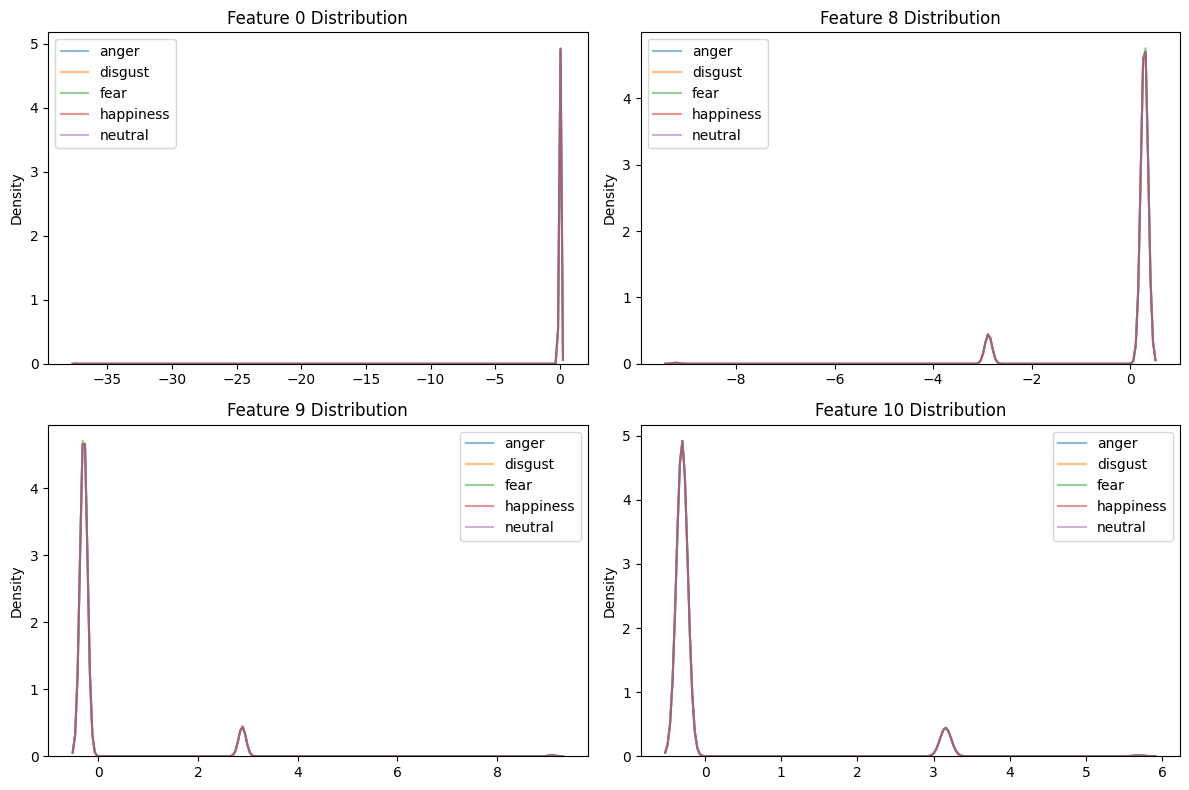

Splitting data...
Train: 11232, Val: 2808, Test: 3510
Building TCN model...
Training TCN model...
Epoch 1/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.1946 - loss: 1.6353 - val_accuracy: 0.2009 - val_loss: 1.6097 - learning_rate: 0.0010
Epoch 2/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.1966 - loss: 1.6106 - val_accuracy: 0.1959 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 3/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.1996 - loss: 1.6098 - val_accuracy: 0.1998 - val_loss: 1.6095 - learning_rate: 0.0010
Epoch 4/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.1928 - loss: 1.6100 - val_accuracy: 0.1998 - val_loss: 1.6095 - learning_rate: 0.0010
Epoch 5/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.1945 - loss: 1.6099 - val_accuracy: 0.2001 - val_loss: 1.6095 - learning_rate: 0.0010
Epoch 6/50
702/702 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2001 - loss: 1.6100 - val_accuracy: 0.1998 - val_loss: 1.6095 - learn

/home/saihan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/saihan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/saihan/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

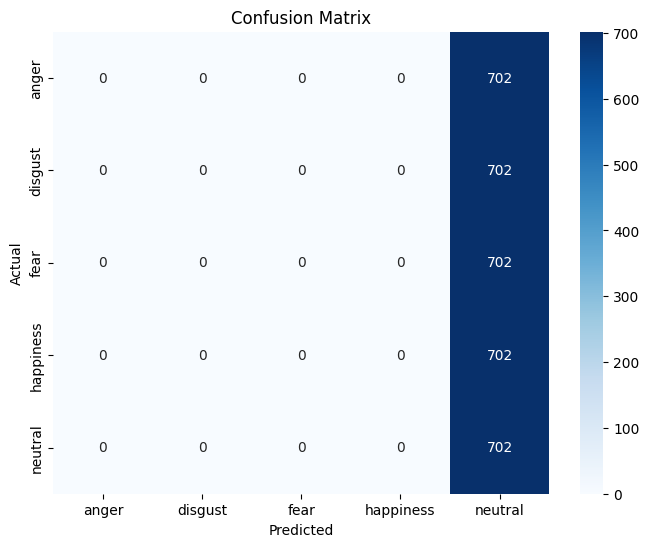

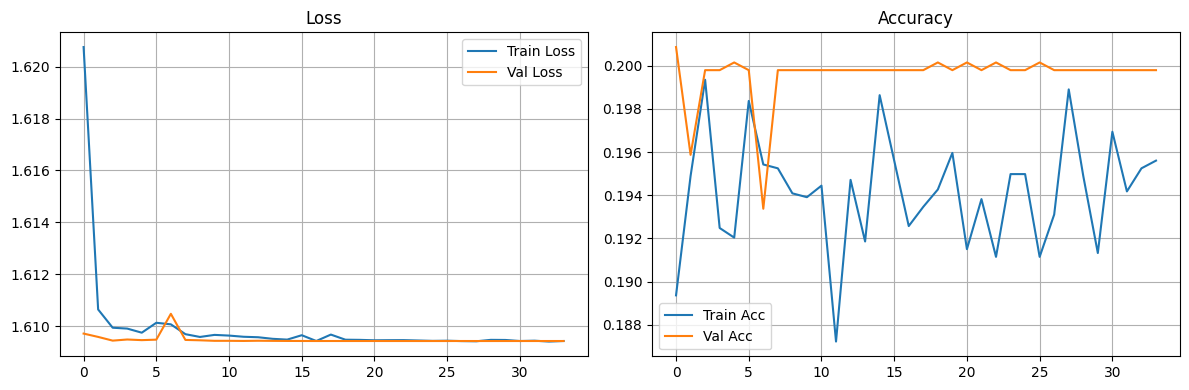

Visualizing embeddings...
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


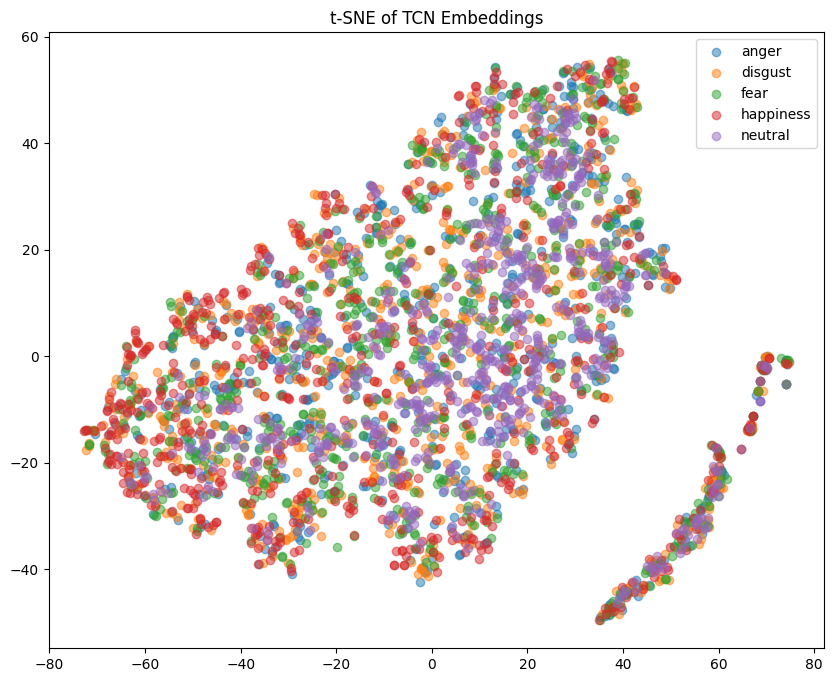

In [25]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tcn import TCN

# --- Configuration ---
DATA_ROOT = "/home/saihan/New folder/data"
SELECTED_EMOTIONS = ['anger', 'disgust', 'fear', 'happiness', 'neutral']
FILES_PER_EMOTION = 10
SEGMENT_LENGTH = 128
EMBEDDING_DIM = 256
BATCH_SIZE = 16
EPOCHS = 50
NUM_FEATURES = 11  # 8 raw + 3 time-domain (mean, variance, RMS)
AUGMENT_NOISE_STD = 0.01
MIN_TIME_STEPS = 45000

# --- Feature Extraction ---
def extract_features(segments):
    """Extract time-domain features per segment across all channels."""
    # Compute mean, variance, RMS across all channels
    mean = np.mean(segments, axis=(1, 2), keepdims=True)  # [n_segments, 1, 1]
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    # Repeat across time and feature dimensions
    mean = np.repeat(np.repeat(mean, SEGMENT_LENGTH, axis=1), 1, axis=2)  # [n_segments, 128, 1]
    variance = np.repeat(np.repeat(variance, SEGMENT_LENGTH, axis=1), 1, axis=2)
    rms = np.repeat(np.repeat(rms, SEGMENT_LENGTH, axis=1), 1, axis=2)
    return np.concatenate([segments, mean, variance, rms], axis=2)  # [n_segments, 128, 11]

# --- Data Loading ---
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    emotion_dirs = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d)) and d in selected_emotions])
    
    for idx, emotion in enumerate(emotion_dirs):
        emotion_path = os.path.join(data_root, emotion)
        emotion_data = []
        for i in range(1, files_per_emotion + 1):
            file_path = os.path.join(emotion_path, f"{emotion}_{i}.npy")
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            try:
                emg = np.load(file_path)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    emotion_data.append(emg)
                    print(f"Loaded {file_path}: Shape {emg.shape}")
                else:
                    print(f"Invalid shape or length in {file_path}: {emg.shape}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if emotion_data:
            data.extend(emotion_data)
            labels.extend([idx] * len(emotion_data))
            emotion_names.append(emotion)
        else:
            print(f"No valid data for emotion: {emotion}")
    
    if not data:
        raise ValueError("No valid data loaded!")
    return data, labels, emotion_names

# --- Data Preprocessing ---
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            print(f"Skipping sample with length {data.shape[0]} < {segment_length}")
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        print(f"Sample shape after reshape: {reshaped.shape}")
        segment_data = extract_features(reshaped)
        print(f"Sample shape after feature extraction: {segment_data.shape}")
        segments.append(segment_data)
        segment_labels.extend([label] * n_segments)
    
    if not segments:
        raise ValueError("No segments created!")
    
    segments = np.concatenate(segments, axis=0)
    print(f"Concatenated segments shape: {segments.shape}")
    scaler = StandardScaler()
    reshaped = segments.reshape(-1, NUM_FEATURES)
    print(f"Flattened shape for scaling: {reshaped.shape}")
    scaled = scaler.fit_transform(reshaped)
    segments = scaled.reshape(segments.shape[0], segment_length, NUM_FEATURES)
    print(f"Final preprocessed shape: {segments.shape}")
    unique, counts = np.unique(segment_labels, return_counts=True)
    print("Segments per class:", dict(zip([SELECTED_EMOTIONS[i] for i in unique], counts)))
    return segments, np.array(segment_labels), scaler

# --- TCN Model ---
def create_tcn_encoder(segment_length, num_features, embedding_dim):
    inputs = Input(shape=(segment_length, num_features))
    x = TCN(nb_filters=32, kernel_size=3, dilations=[1, 2, 4], 
            padding='causal', dropout_rate=0.2, return_sequences=False)(inputs)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    embedding = Dense(embedding_dim, activation='relu', name='segment_embedding')(x)
    return Model(inputs=inputs, outputs=embedding)

# --- Classification Model ---
def create_classification_model(encoder, num_classes):
    x = encoder.output
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=encoder.input, outputs=output)

# --- Training ---
def train_tcn_model(model, X_train, y_train, X_val, y_val):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks,
                       class_weight=class_weights, verbose=1)
    return history

# --- Visualization ---
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def plot_feature_distributions(segments, labels, emotion_names):
    plt.figure(figsize=(12, 8))
    for i, feature_idx in enumerate([0, 8, 9, 10]):  # Raw channel 1, mean, variance, RMS
        plt.subplot(2, 2, i+1)
        for j, name in enumerate(emotion_names):
            mask = labels == j
            feature_values = segments[mask, :, feature_idx].flatten()
            sns.kdeplot(feature_values, label=name, alpha=0.5)
        plt.title(f"Feature {feature_idx} Distribution")
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_embeddings(embeddings, labels, emotion_names):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(emotion_names):
        mask = labels == i
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], label=name, alpha=0.5)
    plt.legend()
    plt.title("t-SNE of TCN Embeddings")
    plt.show()

# --- Main Function ---
def main():
    print("TensorFlow version:", tf.__version__)
    print("GPU available:", tf.config.list_physical_devices('GPU'))
    print("CUDA_VISIBLE_DEVICES:", os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set'))

    print("Loading data...")
    try:
        data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION, SELECTED_EMOTIONS)
        print(f"Loaded {len(data_list)} files, {len(emotion_names)} emotions: {emotion_names}")
        for i, (data, label) in enumerate(zip(data_list, labels)):
            print(f"Sample {i+1}: Shape {data.shape}, Emotion {emotion_names[label]}")
    except ValueError as e:
        print(f"Data loading failed: {e}")
        return

    print("Preprocessing data...")
    try:
        segments, segment_labels, scaler = preprocess_data(data_list, labels, SEGMENT_LENGTH)
    except ValueError as e:
        print(f"Preprocessing failed: {e}")
        return

    print("Visualizing feature distributions...")
    plot_feature_distributions(segments, segment_labels, emotion_names)

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

    print("Building TCN model...")
    tcn_encoder = create_tcn_encoder(SEGMENT_LENGTH, NUM_FEATURES, EMBEDDING_DIM)
    model = create_classification_model(tcn_encoder, num_classes=len(emotion_names))
    
    print("Training TCN model...")
    try:
        history = train_tcn_model(model, X_train, y_train, X_val, y_val)
    except Exception as e:
        print(f"TCN training failed: {e}")
        return

    print("Evaluating TCN model...")
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=emotion_names))
    plot_confusion_matrix(y_test, y_pred, emotion_names)
    plot_training_history(history)

    print("Visualizing embeddings...")
    embeddings = tcn_encoder.predict(X_test)
    plot_embeddings(embeddings, y_test, emotion_names)

if __name__ == "__main__":
    main()

2025-07-06 15:27:21.792464: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-06 15:27:21.563026: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.16.1
GPU available: []
CUDA_VISIBLE_DEVICES: Not set
Loading data...
Loaded /home/saihan/New folder/data/anger/anger_1.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_2.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_3.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_4.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_5.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_6.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_7.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_8.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_9.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_10.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anxiety/anxiety_1.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anxiety/anxiety_2.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/

2025-07-06 15:27:27.059034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-06 15:27:27.297006: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loaded /home/saihan/New folder/data/happiness/happiness_10.npy: Shape (45000, 8)
Loaded 40 files, 4 emotions: ['anger', 'anxiety', 'fear', 'happiness']
Sample 1: Shape (45000, 8), Emotion anger
Sample 2: Shape (45000, 8), Emotion anger
Sample 3: Shape (45000, 8), Emotion anger
Sample 4: Shape (45000, 8), Emotion anger
Sample 5: Shape (45000, 8), Emotion anger
Sample 6: Shape (45000, 8), Emotion anger
Sample 7: Shape (45000, 8), Emotion anger
Sample 8: Shape (45000, 8), Emotion anger
Sample 9: Shape (45000, 8), Emotion anger
Sample 10: Shape (45000, 8), Emotion anger
Sample 11: Shape (45000, 8), Emotion anxiety
Sample 12: Shape (45000, 8), Emotion anxiety
Sample 13: Shape (45000, 8), Emotion anxiety
Sample 14: Shape (45000, 8), Emotion anxiety
Sample 15: Shape (45000, 8), Emotion anxiety
Sample 16: Shape (45000, 8), Emotion anxiety
Sample 17: Shape (45000, 8), Emotion anxiety
Sample 18: Shape (45000, 8), Emotion anxiety
Sample 19: Shape (45000, 8), Emotion anxiety
Sample 20: Shape (4500

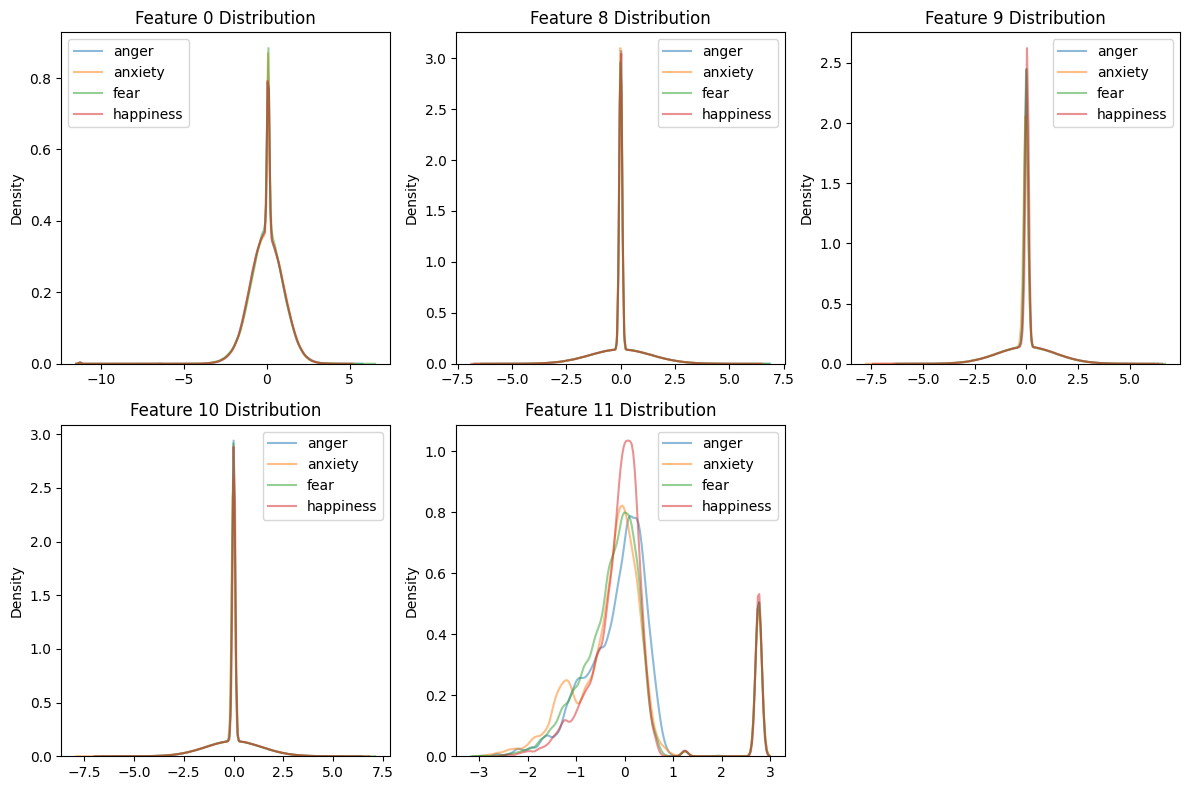

Splitting data...
Train: 17971, Val: 4493, Test: 5616
Building TCN model...
Training TCN model...
Epoch 1/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.2754 - loss: 0.0532 - val_accuracy: 0.4369 - val_loss: 0.0403 - learning_rate: 0.0010
Epoch 2/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.4259 - loss: 0.0412 - val_accuracy: 0.4264 - val_loss: 0.0377 - learning_rate: 0.0010
Epoch 3/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.4393 - loss: 0.0384 - val_accuracy: 0.4545 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 4/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.4412 - loss: 0.0376 - val_accuracy: 0.4440 - val_loss: 0.0376 - learning_rate: 0.0010
Epoch 5/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - accuracy: 0.4645 - loss: 0.0367 - val_accuracy: 0.4723 - val_loss: 0.0343 - learning_rate: 0.0010
Epoch 6/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.4843 - loss: 0.0362 - val_accuracy: 0.5003 - val_los

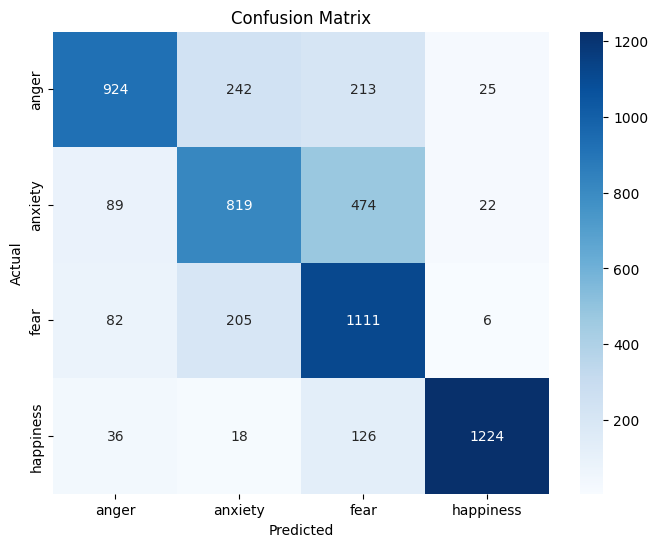

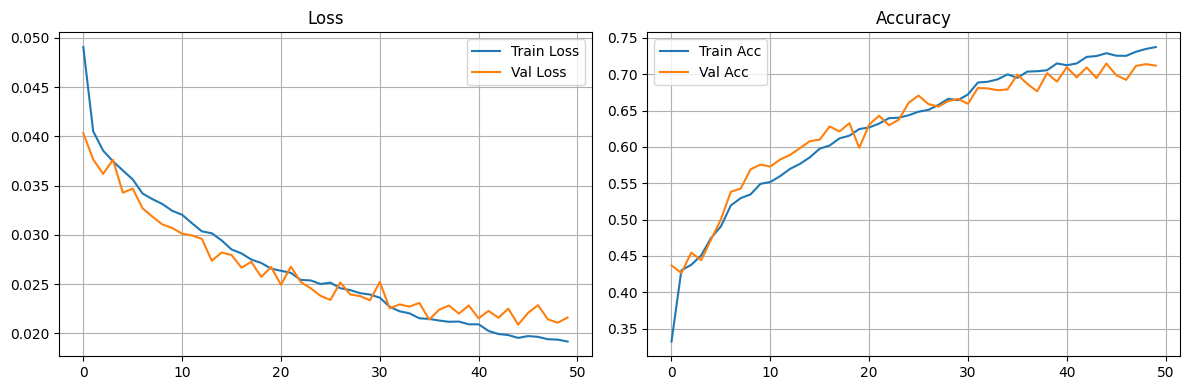

Visualizing embeddings...
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step


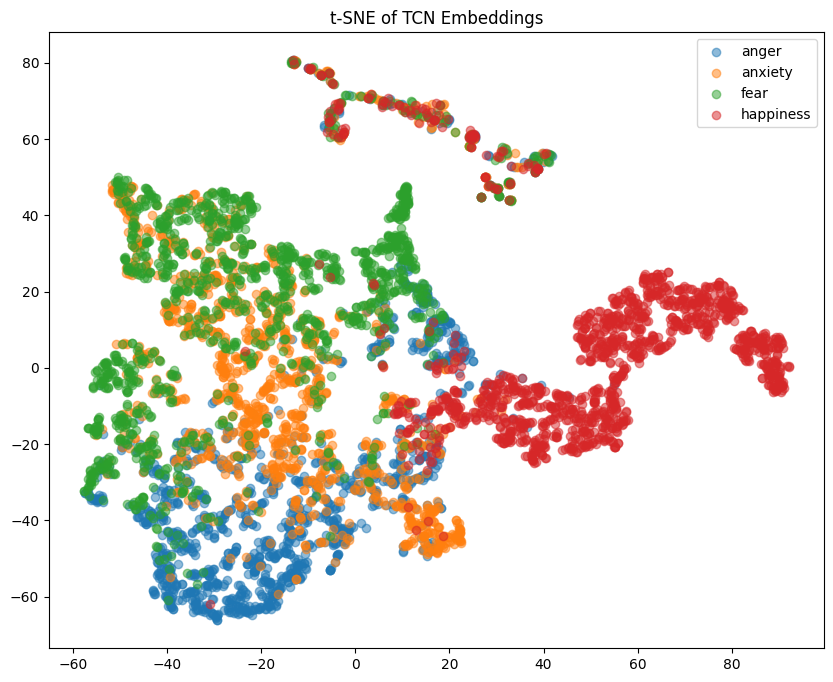

Model saved ✅


In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Layer, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tcn import TCN
from scipy.fft import fft

# --- Configuration ---
DATA_ROOT = "/home/saihan/New folder/data"
SELECTED_EMOTIONS = ['anger', 'anxiety', 'fear', 'happiness']
FILES_PER_EMOTION = 10
SEGMENT_LENGTH = 128
EMBEDDING_DIM = 256
BATCH_SIZE = 16
EPOCHS = 50
NUM_FEATURES = 12  # 8 raw + 3 time-domain + 1 frequency-domain
AUGMENT_NOISE_STD = 0.01
MIN_TIME_STEPS = 45000

# --- Focal Loss ---
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        pt = tf.where(y_true_one_hot == 1, y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fn

# --- Custom Attention Layer ---
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.dense = Dense(1, activation='tanh')
        self.softmax = Softmax(axis=1)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention = self.dense(inputs)
        attention = self.softmax(attention)
        weighted = inputs * attention
        return tf.reduce_sum(weighted, axis=1)  # [batch, nb_filters]

# --- Feature Extraction ---
def extract_features(segments):
    """Extract time- and frequency-domain features per segment across all channels."""
    segments = (segments - np.mean(segments, axis=1, keepdims=True)) / (np.std(segments, axis=1, keepdims=True) + 1e-8)
    mean = np.mean(segments, axis=(1, 2), keepdims=True)  # [n_segments, 1, 1]
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    freq = np.abs(fft(segments, axis=1))[:, :SEGMENT_LENGTH//2]  # [n_segments, 64, 8]
    mean_freq = np.mean(freq, axis=(1, 2), keepdims=True)  # [n_segments, 1, 1]
    mean = np.repeat(np.repeat(mean, SEGMENT_LENGTH, axis=1), 1, axis=2)
    variance = np.repeat(np.repeat(variance, SEGMENT_LENGTH, axis=1), 1, axis=2)
    rms = np.repeat(np.repeat(rms, SEGMENT_LENGTH, axis=1), 1, axis=2)
    mean_freq = np.repeat(np.repeat(mean_freq, SEGMENT_LENGTH, axis=1), 1, axis=2)
    return np.concatenate([segments, mean, variance, rms, mean_freq], axis=2)  # [n_segments, 128, 12]

# --- Data Loading ---
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    emotion_dirs = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d)) and d in selected_emotions])
    
    for idx, emotion in enumerate(emotion_dirs):
        emotion_path = os.path.join(data_root, emotion)
        emotion_data = []
        for i in range(1, files_per_emotion + 1):
            file_path = os.path.join(emotion_path, f"{emotion}_{i}.npy")
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            try:
                emg = np.load(file_path)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    emotion_data.append(emg)
                    print(f"Loaded {file_path}: Shape {emg.shape}")
                else:
                    print(f"Invalid shape or length in {file_path}: {emg.shape}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if emotion_data:
            data.extend(emotion_data)
            labels.extend([idx] * len(emotion_data))
            emotion_names.append(emotion)
        else:
            print(f"No valid data for emotion: {emotion}")
    
    if not data:
        raise ValueError("No valid data loaded!")
    return data, labels, emotion_names

# --- Data Preprocessing ---
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            print(f"Skipping sample with length {data.shape[0]} < {segment_length}")
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        print(f"Sample shape after reshape: {reshaped.shape}")
        segment_data = extract_features(reshaped)
        print(f"Sample shape after feature extraction: {segment_data.shape}")
        noise = np.random.normal(0, AUGMENT_NOISE_STD, segment_data.shape)
        segments.append(segment_data + noise)
        segments.append(segment_data)
        segment_labels.extend([label] * n_segments * 2)
    
    if not segments:
        raise ValueError("No segments created!")
    
    segments = np.concatenate(segments, axis=0)
    print(f"Concatenated segments shape: {segments.shape}")
    scaler = StandardScaler()
    reshaped = segments.reshape(-1, NUM_FEATURES)
    print(f"Flattened shape for scaling: {reshaped.shape}")
    scaled = scaler.fit_transform(reshaped)
    segments = scaled.reshape(segments.shape[0], segment_length, NUM_FEATURES)
    print(f"Final preprocessed shape: {segments.shape}")
    unique, counts = np.unique(segment_labels, return_counts=True)
    print("Segments per class:", dict(zip([SELECTED_EMOTIONS[i] for i in unique], counts)))
    return segments, np.array(segment_labels), scaler

# --- TCN Model with Attention ---
def create_tcn_encoder(segment_length, num_features, embedding_dim):
    inputs = Input(shape=(segment_length, num_features))
    x = TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8], 
            padding='causal', dropout_rate=0.2, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    
    # Attention mechanism
    x = AttentionLayer()(x)  # [batch, nb_filters]
    
    # Residual connection
    x2 = TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4], 
             padding='causal', dropout_rate=0.2, return_sequences=False)(inputs)
    x2 = BatchNormalization()(x2)
    x = Add()([x, x2])
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    embedding = Dense(embedding_dim, activation='relu', name='segment_embedding')(x)
    return Model(inputs=inputs, outputs=embedding)

# --- Classification Model ---
def create_classification_model(encoder, num_classes):
    x = encoder.output
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=encoder.input, outputs=output)

# --- Training ---
def train_tcn_model(model, X_train, y_train, X_val, y_val):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    model.compile(optimizer=Adam(1e-3, clipnorm=1.0), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks,
                       class_weight=class_weights, verbose=1)
    return history

# --- Visualization ---
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def plot_feature_distributions(segments, labels, emotion_names):
    plt.figure(figsize=(12, 8))
    for i, feature_idx in enumerate([0, 8, 9, 10, 11]):  # Raw channel 1, mean, variance, RMS, mean_freq
        plt.subplot(2, 3, i+1)
        for j, name in enumerate(emotion_names):
            mask = labels == j
            feature_values = segments[mask, :, feature_idx].flatten()
            sns.kdeplot(feature_values, label=name, alpha=0.5)
        plt.title(f"Feature {feature_idx} Distribution")
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_embeddings(embeddings, labels, emotion_names):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(emotion_names):
        mask = labels == i
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], label=name, alpha=0.5)
    plt.legend()
    plt.title("t-SNE of TCN Embeddings")
    plt.show()

# --- Main Function ---
def main():
    print("TensorFlow version:", tf.__version__)
    print("GPU available:", tf.config.list_physical_devices('GPU'))
    print("CUDA_VISIBLE_DEVICES:", os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set'))

    print("Loading data...")
    try:
        data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION, SELECTED_EMOTIONS)
        print(f"Loaded {len(data_list)} files, {len(emotion_names)} emotions: {emotion_names}")
        for i, (data, label) in enumerate(zip(data_list, labels)):
            print(f"Sample {i+1}: Shape {data.shape}, Emotion {emotion_names[label]}")
    except ValueError as e:
        print(f"Data loading failed: {e}")
        return

    print("Preprocessing data...")
    try:
        segments, segment_labels, scaler = preprocess_data(data_list, labels, SEGMENT_LENGTH)
    except ValueError as e:
        print(f"Preprocessing failed: {e}")
        return

    print("Visualizing feature distributions...")
    plot_feature_distributions(segments, segment_labels, emotion_names)

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

    print("Building TCN model...")
    try:
        tcn_encoder = create_tcn_encoder(SEGMENT_LENGTH, NUM_FEATURES, EMBEDDING_DIM)
        model = create_classification_model(tcn_encoder, num_classes=len(emotion_names))
    except Exception as e:
        print(f"Model building failed: {e}")
        return
    
    print("Training TCN model...")
    try:
        history = train_tcn_model(model, X_train, y_train, X_val, y_val)
    except Exception as e:
        print(f"TCN training failed: {e}")
        return

    print("Evaluating TCN model...")
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=emotion_names))
    plot_confusion_matrix(y_test, y_pred, emotion_names)
    plot_training_history(history)

    print("Visualizing embeddings...")
    embeddings = tcn_encoder.predict(X_test)
    plot_embeddings(embeddings, y_test, emotion_names)

    model.save("emotion_tcn_model.keras")
  # Saves model right after training
    print("Model saved ✅")


if __name__ == "__main__":
    main()

Loading data ...
Pre-processing ...
Splitting ...
Train: 17971 Val: 4493 Test: 5616
Building CNN ...
Training CNN ...
Epoch 1/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.4589 - loss: 0.0437 - val_accuracy: 0.6014 - val_loss: 0.0299 - learning_rate: 0.0010
Epoch 2/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.5965 - loss: 0.0304 - val_accuracy: 0.6399 - val_loss: 0.0263 - learning_rate: 0.0010
Epoch 3/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.6279 - loss: 0.0280 - val_accuracy: 0.6584 - val_loss: 0.0252 - learning_rate: 0.0010
Epoch 4/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.6611 - loss: 0.0256 - val_accuracy: 0.7029 - val_loss: 0.0227 - learning_rate: 0.0010
Epoch 5/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.6878 - loss: 0.0241 - val_accuracy: 0.7534 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 6/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.7094 - loss: 0.0227 - val_accura

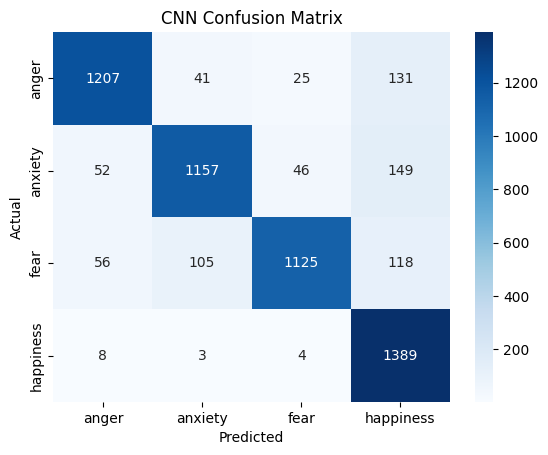

CNN saved ✅


In [10]:
# ╔═══════════════════════════════════════════════════════════════════════╗
# ║  🔗  CNN-only pipeline – 12-D EMG features, focal-loss, class-weights ║
# ╚═══════════════════════════════════════════════════════════════════════╝
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft

# ---------- CONSTANTS (identical to TCN script) ----------
DATA_ROOT          = "/home/saihan/New folder/data"
SELECTED_EMOTIONS  = ['anger', 'anxiety', 'fear', 'happiness']
FILES_PER_EMOTION  = 10
SEGMENT_LENGTH     = 128
EMBEDDING_DIM      = 256
BATCH_SIZE         = 16
EPOCHS             = 50
NUM_FEATURES       = 12   # 8 raw + 3 time-domain + 1 frequency
AUGMENT_NOISE_STD  = 0.01
MIN_TIME_STEPS     = 45000

# ---------- FOCAL LOSS ----------
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        pt = tf.where(y_true_one_hot == 1, y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fn

# ---------- FEATURE EXTRACTION (same as TCN) ----------
def extract_features(segments):
    segments = (segments - np.mean(segments, axis=1, keepdims=True)) / (np.std(segments, axis=1, keepdims=True) + 1e-8)
    mean = np.mean(segments, axis=(1, 2), keepdims=True)
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    freq = np.abs(fft(segments, axis=1))[:, :SEGMENT_LENGTH//2]
    mean_freq = np.mean(freq, axis=(1, 2), keepdims=True)
    for feat in (mean, variance, rms, mean_freq):
        segments = np.concatenate([segments, np.repeat(feat, SEGMENT_LENGTH, axis=1)], axis=2)
    return segments

# ---------- DATA LOADING ----------
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    for idx, emotion in enumerate(sorted([d for d in os.listdir(data_root) if d in selected_emotions])):
        for i in range(1, files_per_emotion + 1):
            fp = os.path.join(data_root, emotion, f"{emotion}_{i}.npy")
            if os.path.exists(fp):
                emg = np.load(fp)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    data.append(emg)
                    labels.append(idx)
        emotion_names.append(emotion)
    return data, labels, emotion_names

# ---------- PRE-PROCESS ----------
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        segment_data = extract_features(reshaped)
        noise = np.random.normal(0, AUGMENT_NOISE_STD, segment_data.shape)
        segments.extend([segment_data + noise, segment_data])
        segment_labels.extend([label] * n_segments * 2)
    segments = np.concatenate(segments)
    scaler = StandardScaler()
    flat = segments.reshape(-1, NUM_FEATURES)
    segments = scaler.fit_transform(flat).reshape(segments.shape)
    return segments, np.array(segment_labels), scaler

# ---------- CNN ARCHITECTURE ----------
def build_cnn(segment_length, num_features, embedding_dim, num_classes):
    inputs = Input(shape=(segment_length, num_features))

    x = Conv1D(64, 5, padding='causal', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(128, 5, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(256, 3, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(512, 3, padding='causal', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)  # instead of Flatten → smaller model
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(embedding_dim, activation='relu', name='segment_embedding')(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inputs, outputs=out)

# ---------- TRAIN ----------def train_model(model, X_train, y_train, X_val, y_val):
def train_model(model, X_train, y_train, X_val, y_val):
    weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train)
    weights = dict(enumerate(weights))

    model.compile(
        optimizer=Adam(1e-3),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy'])

    cbs = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    return model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=weights,
        callbacks=cbs,
        verbose=1)

# ---------- EVALUATE ----------
def evaluate(model, X_test, y_test, labels):
    y_pred = np.argmax(model.predict(X_test, batch_size=BATCH_SIZE), axis=1)
    print(classification_report(y_test, y_pred, target_names=labels))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("CNN Confusion Matrix")
    plt.show()

print("Loading data ...")
data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION, SELECTED_EMOTIONS)
print("Pre-processing ...")
segments, segment_labels, _ = preprocess_data(data_list, labels, SEGMENT_LENGTH)
print("Splitting ...")
X_train, X_test, y_train, y_test = train_test_split(
    segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
print("Train:", X_train.shape[0], "Val:", X_val.shape[0], "Test:", X_test.shape[0])
print("Building CNN ...")
model = build_cnn(SEGMENT_LENGTH, NUM_FEATURES, EMBEDDING_DIM, len(emotion_names))

print("Training CNN ...")
history = train_model(model, X_train, y_train, X_val, y_val)  # Fixed here

print("Evaluating CNN ...")
evaluate(model, X_test, y_test, emotion_names)

model.save("emotion_cnn_model.keras")
print("CNN saved ✅")

In [2]:
!pip install tensorflow==2.16.1

  Using cached tensorflow-2.16.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached ml_dtypes-0.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
Using cached tensorflow-2.16.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.9 MB)
Using cached ml_dtypes-0.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.

2025-07-20 01:48:47.515087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-20 01:48:49.931134: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading data ...
Pre-processing ...
Splitting ...
Train: 17971 Val: 4493 Test: 5616
Building TCN ...


2025-07-20 01:49:00.896952: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-20 01:49:01.230854: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Training TCN ...
Epoch 1/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 164s 134ms/step - accuracy: 0.4650 - loss: 0.0457 - val_accuracy: 0.5807 - val_loss: 0.0311 - learning_rate: 0.0010
Epoch 2/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 138s 123ms/step - accuracy: 0.5880 - loss: 0.0308 - val_accuracy: 0.5858 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 3/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 134s 119ms/step - accuracy: 0.6217 - loss: 0.0285 - val_accuracy: 0.6041 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 4/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 132s 118ms/step - accuracy: 0.6393 - loss: 0.0273 - val_accuracy: 0.6702 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 5/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 135s 120ms/step - accuracy: 0.6664 - loss: 0.0257 - val_accuracy: 0.6599 - val_loss: 0.0234 - learning_rate: 0.0010
Epoch 6/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 130s 116ms/step - accuracy: 0.6823 - loss: 0.0246 - val_accuracy: 0.7169 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 7/50
1124/1124 ━━━━━━━━━━━━━━

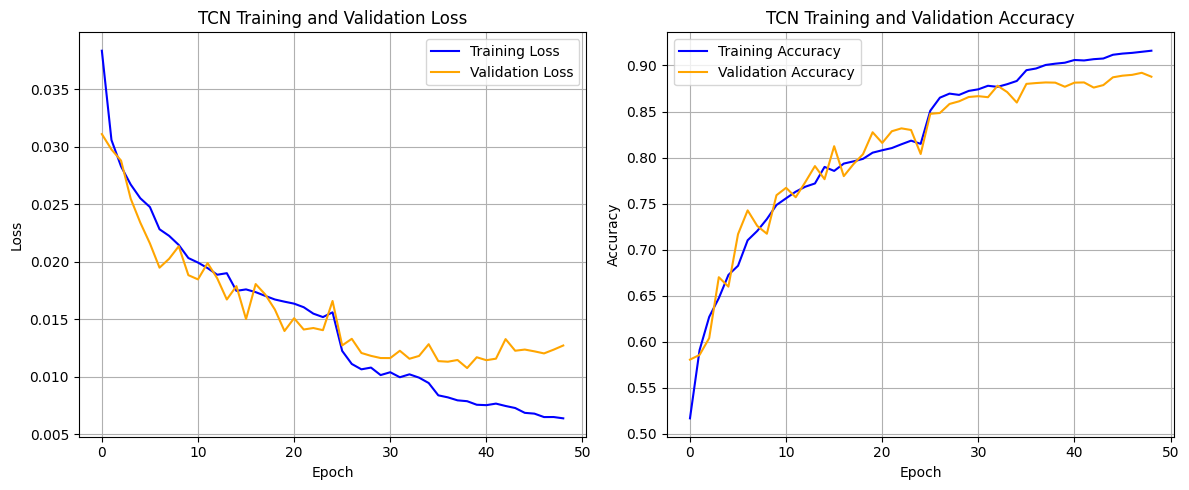

Evaluating TCN ...
351/351 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step
              precision    recall  f1-score   support

       anger       0.92      0.88      0.90      1404
     anxiety       0.94      0.83      0.88      1404
        fear       0.94      0.85      0.89      1404
   happiness       0.79      0.99      0.88      1404

    accuracy                           0.89      5616
   macro avg       0.90      0.89      0.89      5616
weighted avg       0.90      0.89      0.89      5616



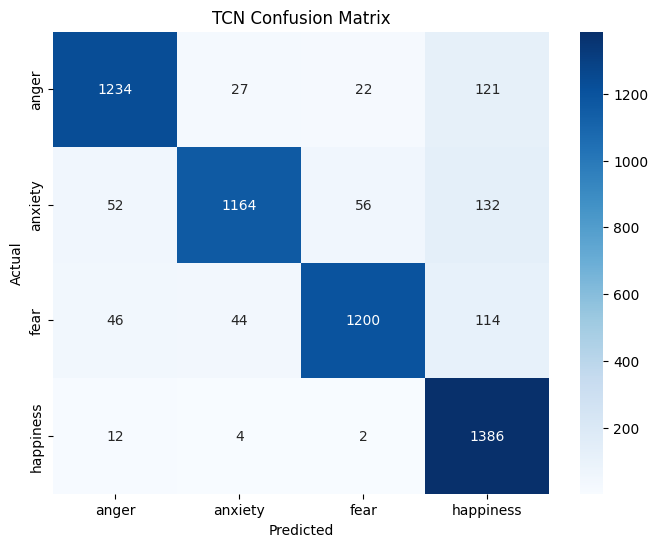

TCN saved ✅


In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Dense, Dropout, BatchNormalization, 
    GlobalAveragePooling1D, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft

# ---------- CONSTANTS ----------
DATA_ROOT          = "/home/saihan/New folder/data"
SELECTED_EMOTIONS  = ['anger', 'anxiety', 'fear', 'happiness']
FILES_PER_EMOTION  = 10
SEGMENT_LENGTH     = 128
EMBEDDING_DIM      = 256
BATCH_SIZE         = 16
EPOCHS             = 50
NUM_FEATURES       = 12   # 8 raw + 3 time-domain + 1 frequency
AUGMENT_NOISE_STD  = 0.01
MIN_TIME_STEPS     = 45000

# ---------- FOCAL LOSS ----------
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        pt = tf.where(y_true_one_hot == 1, y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fn

# ---------- FEATURE EXTRACTION ----------
def extract_features(segments):
    segments = (segments - np.mean(segments, axis=1, keepdims=True)) / (np.std(segments, axis=1, keepdims=True) + 1e-8)
    mean = np.mean(segments, axis=(1, 2), keepdims=True)
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    freq = np.abs(fft(segments, axis=1))[:, :SEGMENT_LENGTH//2]
    mean_freq = np.mean(freq, axis=(1, 2), keepdims=True)
    for feat in (mean, variance, rms, mean_freq):
        segments = np.concatenate([segments, np.repeat(feat, SEGMENT_LENGTH, axis=1)], axis=2)
    return segments

# ---------- DATA LOADING ----------
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    for idx, emotion in enumerate(sorted([d for d in os.listdir(data_root) if d in selected_emotions])):
        for i in range(1, files_per_emotion + 1):
            fp = os.path.join(data_root, emotion, f"{emotion}_{i}.npy")
            if os.path.exists(fp):
                emg = np.load(fp)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    data.append(emg)
                    labels.append(idx)
        emotion_names.append(emotion)
    return data, labels, emotion_names

# ---------- PRE-PROCESS ----------
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        segment_data = extract_features(reshaped)
        noise = np.random.normal(0, AUGMENT_NOISE_STD, segment_data.shape)
        segments.extend([segment_data + noise, segment_data])
        segment_labels.extend([label] * n_segments * 2)
    segments = np.concatenate(segments)
    scaler = StandardScaler()
    flat = segments.reshape(-1, NUM_FEATURES)
    segments = scaler.fit_transform(flat).reshape(segments.shape)
    return segments, np.array(segment_labels), scaler

# ---------- TCN ARCHITECTURE ----------
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate):
        super(ResidualBlock, self).__init__()
        self.conv1 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate, activation='relu')
        self.bn2 = BatchNormalization()
        self.shortcut = Conv1D(filters, 1, padding='causal') if filters != NUM_FEATURES else tf.keras.layers.Lambda(lambda x: x)
        self.add = Add()
        self.dropout = Dropout(0.2)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        shortcut = self.shortcut(inputs)
        x = self.add([x, shortcut])
        x = self.dropout(x, training=training)
        return x

def build_tcn(segment_length, num_features, embedding_dim, num_classes):
    inputs = Input(shape=(segment_length, num_features))
    
    x = inputs
    for filters, dilation in [(64, 1), (128, 2), (256, 4), (512, 8)]:
        x = ResidualBlock(filters, kernel_size=3, dilation_rate=dilation)(x)
    
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(embedding_dim, activation='relu', name='segment_embedding')(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=out)

# ---------- TRAIN ----------
def train_model(model, X_train, y_train, X_val, y_val):
    weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train)
    weights = dict(enumerate(weights))

    model.compile(
        optimizer=Adam(1e-3),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy'])

    cbs = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=weights,
        callbacks=cbs,
        verbose=1)
    
    return history

# ---------- VISUALIZE TRAINING HISTORY ----------
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot Loss
    ax1.plot(history.history['loss'], label='Training Loss', color='blue')
    ax1.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    ax1.set_title('TCN Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot Accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    ax2.set_title('TCN Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# ---------- EVALUATE ----------
def evaluate(model, X_test, y_test, labels):
    y_pred = np.argmax(model.predict(X_test, batch_size=BATCH_SIZE), axis=1)
    print(classification_report(y_test, y_pred, target_names=labels))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("TCN Confusion Matrix")
    plt.show()

print("Loading data ...")
data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION, SELECTED_EMOTIONS)
print("Pre-processing ...")
segments, segment_labels, _ = preprocess_data(data_list, labels, SEGMENT_LENGTH)
print("Splitting ...")
X_train, X_test, y_train, y_test = train_test_split(
    segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
print("Train:", X_train.shape[0], "Val:", X_val.shape[0], "Test:", X_test.shape[0])
print("Building TCN ...")
model = build_tcn(SEGMENT_LENGTH, NUM_FEATURES, EMBEDDING_DIM, len(emotion_names))

print("Training TCN ...")
history = train_model(model, X_train, y_train, X_val, y_val)

print("Visualizing Training History ...")
plot_training_history(history)

print("Evaluating TCN ...")
evaluate(model, X_test, y_test, emotion_names)

model.save("emotion_tcn_model.h5")

print("TCN saved ✅")

Loading data ...
Pre-processing ...
Splitting ...
Building TCN ...
Training TCN ...
Epoch 1/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 162s 129ms/step - accuracy: 0.4781 - loss: 0.0456 - val_accuracy: 0.5834 - val_loss: 0.0295 - learning_rate: 0.0010
Epoch 2/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 140s 124ms/step - accuracy: 0.5999 - loss: 0.0308 - val_accuracy: 0.6027 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 3/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 137s 122ms/step - accuracy: 0.6285 - loss: 0.0280 - val_accuracy: 0.6459 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 4/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 141s 126ms/step - accuracy: 0.6517 - loss: 0.0266 - val_accuracy: 0.7006 - val_loss: 0.0228 - learning_rate: 0.0010
Epoch 5/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 109s 97ms/step - accuracy: 0.6833 - loss: 0.0247 - val_accuracy: 0.6853 - val_loss: 0.0240 - learning_rate: 0.0010
Epoch 6/50
1124/1124 ━━━━━━━━━━━━━━━━━━━━ 104s 93ms/step - accuracy: 0.7081 - loss: 0.0237 - val_accuracy: 0.7383 - val_loss: 0

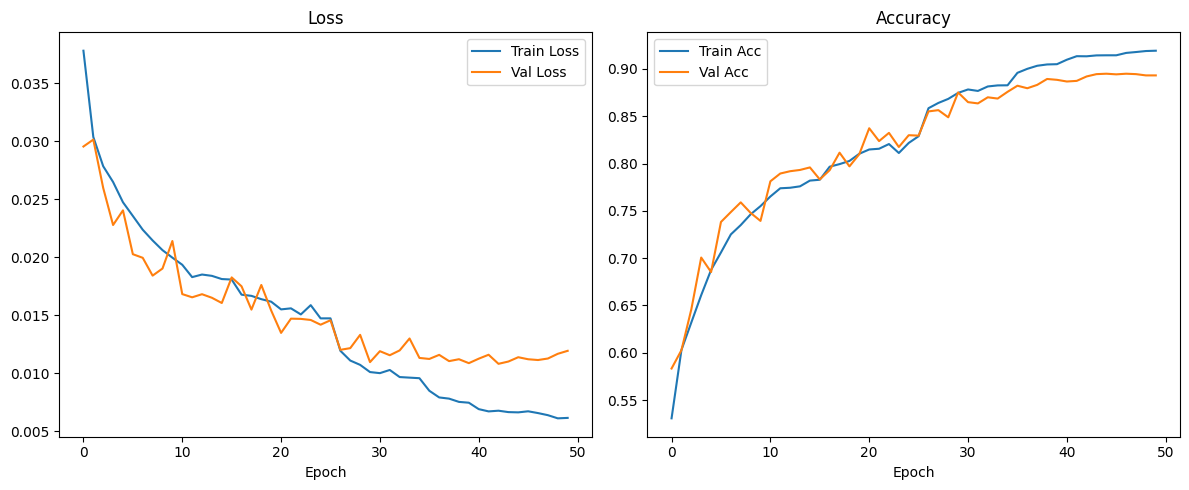

Evaluating ...
351/351 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step
              precision    recall  f1-score   support

       anger       0.94      0.87      0.90      1404
     anxiety       0.94      0.85      0.89      1404
        fear       0.95      0.87      0.91      1404
   happiness       0.78      0.99      0.87      1404

    accuracy                           0.89      5616
   macro avg       0.90      0.89      0.89      5616
weighted avg       0.90      0.89      0.89      5616



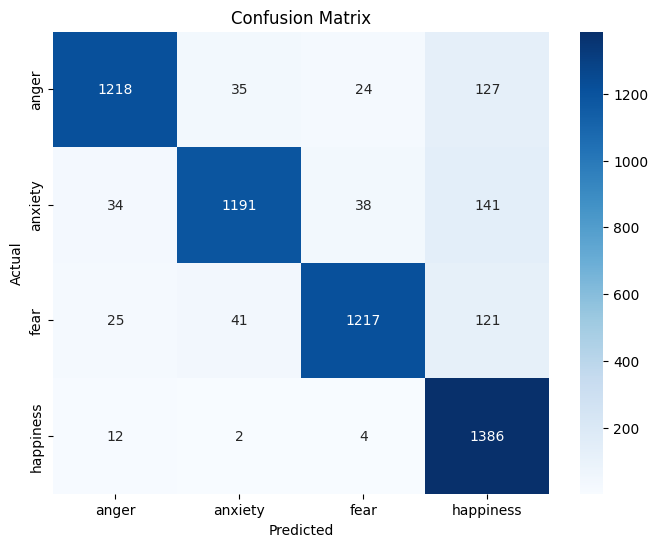

✅ Model saved as 'emotion_tcn_model.keras'


In [4]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling1D, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft

# ---------- CONSTANTS ----------
DATA_ROOT          = "/home/saihan/New folder/data"
SELECTED_EMOTIONS  = ['anger', 'anxiety', 'fear', 'happiness']
FILES_PER_EMOTION  = 10
SEGMENT_LENGTH     = 128
EMBEDDING_DIM      = 256
BATCH_SIZE         = 16
EPOCHS             = 50
NUM_FEATURES       = 12
AUGMENT_NOISE_STD  = 0.01
MIN_TIME_STEPS     = 45000

# ---------- FOCAL LOSS ----------
@tf.keras.utils.register_keras_serializable()
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        pt = tf.where(y_true_one_hot == 1, y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fn

# ---------- FEATURE EXTRACTION ----------
def extract_features(segments):
    segments = (segments - np.mean(segments, axis=1, keepdims=True)) / (np.std(segments, axis=1, keepdims=True) + 1e-8)
    mean = np.mean(segments, axis=(1, 2), keepdims=True)
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    freq = np.abs(fft(segments, axis=1))[:, :SEGMENT_LENGTH//2]
    mean_freq = np.mean(freq, axis=(1, 2), keepdims=True)
    for feat in (mean, variance, rms, mean_freq):
        segments = np.concatenate([segments, np.repeat(feat, SEGMENT_LENGTH, axis=1)], axis=2)
    return segments

# ---------- DATA LOADING ----------
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    for idx, emotion in enumerate(sorted([d for d in os.listdir(data_root) if d in selected_emotions])):
        for i in range(1, files_per_emotion + 1):
            fp = os.path.join(data_root, emotion, f"{emotion}_{i}.npy")
            if os.path.exists(fp):
                emg = np.load(fp)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    data.append(emg)
                    labels.append(idx)
        emotion_names.append(emotion)
    return data, labels, emotion_names

# ---------- PRE-PROCESS ----------
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        segment_data = extract_features(reshaped)
        noise = np.random.normal(0, AUGMENT_NOISE_STD, segment_data.shape)
        segments.extend([segment_data + noise, segment_data])
        segment_labels.extend([label] * n_segments * 2)
    segments = np.concatenate(segments)
    scaler = StandardScaler()
    flat = segments.reshape(-1, NUM_FEATURES)
    segments = scaler.fit_transform(flat).reshape(segments.shape)
    return segments, np.array(segment_labels), scaler

# ---------- TCN ARCHITECTURE ----------
@tf.keras.utils.register_keras_serializable()
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.conv1 = None
        self.conv2 = None
        self.shortcut = None
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        self.dropout = Dropout(0.2)

    def build(self, input_shape):
        input_channels = input_shape[-1]
        self.conv1 = Conv1D(self.filters, self.kernel_size, padding='causal',
                            dilation_rate=self.dilation_rate, activation='relu')
        self.conv2 = Conv1D(self.filters, self.kernel_size, padding='causal',
                            dilation_rate=self.dilation_rate, activation='relu')
        if input_channels != self.filters:
            self.shortcut = Conv1D(self.filters, kernel_size=1, padding='same')
        else:
            self.shortcut = lambda x: x  # Identity shortcut
        super().build(input_shape)

    def call(self, inputs, training=False):
        shortcut = self.shortcut(inputs)
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x += shortcut
        x = self.dropout(x, training=training)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.filters,)

def build_tcn(segment_length, num_features, embedding_dim, num_classes):
    inputs = Input(shape=(segment_length, num_features))
    x = inputs
    for filters, dilation in [(64, 1), (128, 2), (256, 4), (512, 8)]:
        x = ResidualBlock(filters, kernel_size=3, dilation_rate=dilation)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(embedding_dim, activation='relu', name='segment_embedding')(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=inputs, outputs=out)

# ---------- TRAIN ----------
def train_model(model, X_train, y_train, X_val, y_val):
    weights = class_weight.compute_class_weight(
        'balanced', classes=np.unique(y_train), y=y_train)
    weights = dict(enumerate(weights))

    model.compile(
        optimizer=Adam(1e-3),
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy'])

    cbs = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=weights,
        callbacks=cbs,
        verbose=1)

    return history

# ---------- VISUALIZE TRAINING ----------
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax2.plot(history.history['accuracy'], label='Train Acc')
    ax2.plot(history.history['val_accuracy'], label='Val Acc')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.tight_layout()
    plt.show()

# ---------- EVALUATE ----------
def evaluate(model, X_test, y_test, labels):
    y_pred = np.argmax(model.predict(X_test, batch_size=BATCH_SIZE), axis=1)
    print(classification_report(y_test, y_pred, target_names=labels))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# ---------- PIPELINE ----------
print("Loading data ...")
data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION, SELECTED_EMOTIONS)
print("Pre-processing ...")
segments, segment_labels, _ = preprocess_data(data_list, labels, SEGMENT_LENGTH)
print("Splitting ...")
X_train, X_test, y_train, y_test = train_test_split(segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
print("Building TCN ...")
model = build_tcn(SEGMENT_LENGTH, NUM_FEATURES, EMBEDDING_DIM, len(emotion_names))
print("Training TCN ...")
history = train_model(model, X_train, y_train, X_val, y_val)
print("Visualizing Training ...")
plot_training_history(history)
print("Evaluating ...")
evaluate(model, X_test, y_test, emotion_names)
model.save("emotion_tcn_model.keras")
print("✅ Model saved as 'emotion_tcn_model.keras'")


TensorFlow version: 2.16.1
GPU available: []
CUDA_VISIBLE_DEVICES: Not set
Loading data...
Loaded /home/saihan/New folder/data/anger/anger_1.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_2.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_3.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_4.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_5.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_6.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_7.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_8.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_9.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_10.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anxiety/anxiety_1.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anxiety/anxiety_2.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/

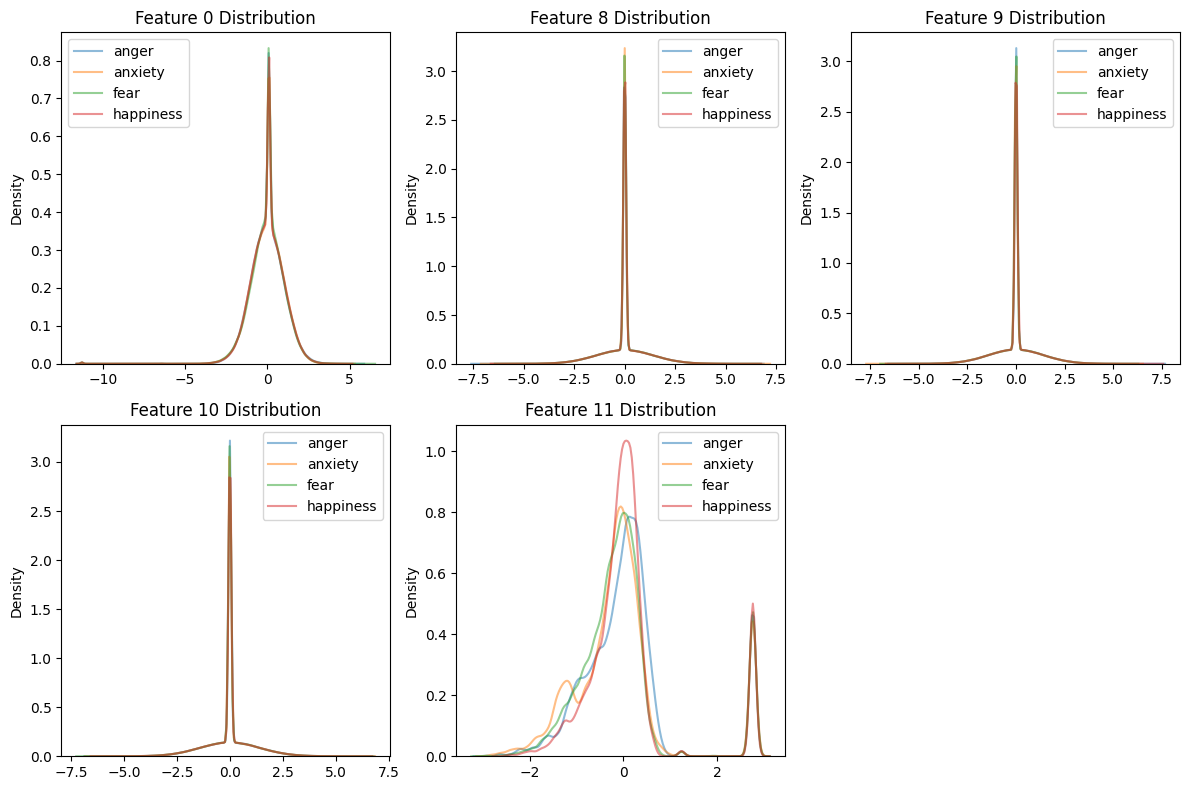

Splitting data...
Train: 17971, Val: 4493, Test: 5616
Building TCN model...
Training TCN model...
Epoch 1/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.2558 - loss: 0.0536 - val_accuracy: 0.4353 - val_loss: 0.0427 - learning_rate: 0.0010
Epoch 2/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.4109 - loss: 0.0436 - val_accuracy: 0.4572 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 3/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.4414 - loss: 0.0384 - val_accuracy: 0.4178 - val_loss: 0.0366 - learning_rate: 0.0010
Epoch 4/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.4419 - loss: 0.0372 - val_accuracy: 0.4952 - val_loss: 0.0346 - learning_rate: 0.0010
Epoch 5/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 22s 39ms/step - accuracy: 0.4822 - loss: 0.0357 - val_accuracy: 0.5019 - val_loss: 0.0352 - learning_rate: 0.0010
Epoch 6/100
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.4907 - loss: 0.0352 - val_accuracy: 0.5090 - val_loss: 0.0

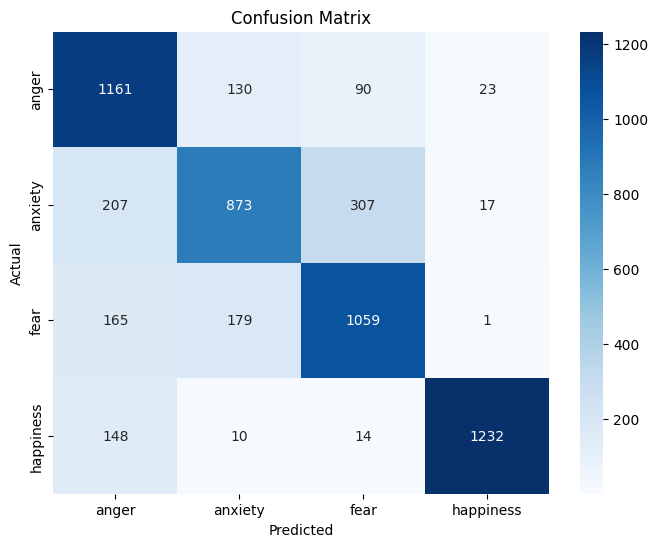

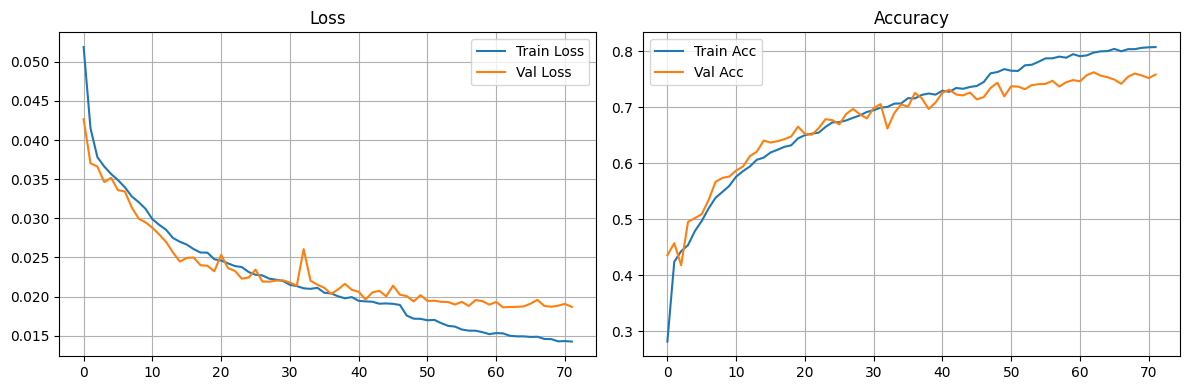

Visualizing embeddings...
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


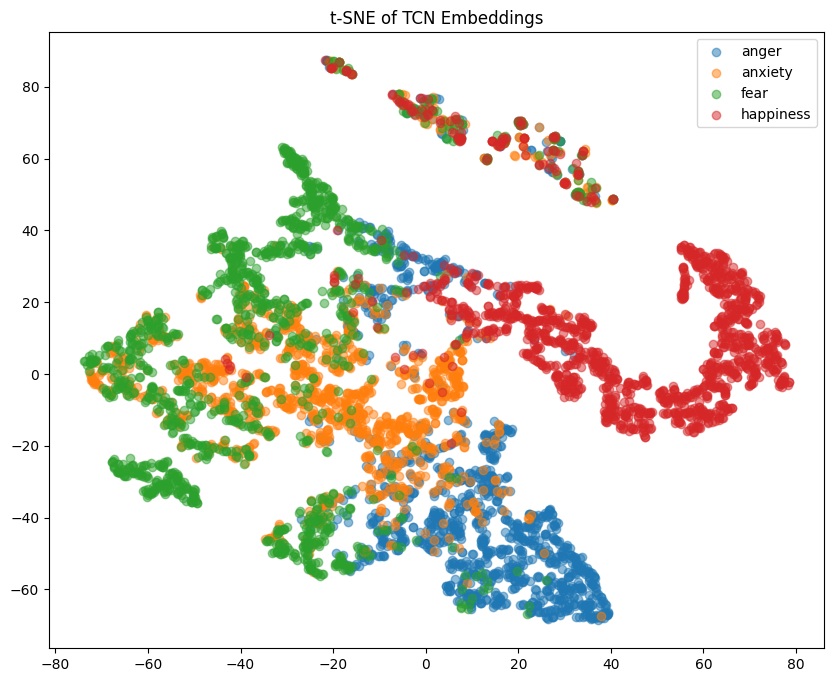

Model saved ✅


In [3]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Layer, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tcn import TCN
from scipy.fft import fft

# --- Configuration ---
DATA_ROOT = "/home/saihan/New folder/data"
SELECTED_EMOTIONS = ['anger', 'anxiety', 'fear', 'happiness']
FILES_PER_EMOTION = 10
SEGMENT_LENGTH = 128
EMBEDDING_DIM = 256
BATCH_SIZE = 32  # Increased batch size
EPOCHS = 100  # Increased epochs
NUM_FEATURES = 12 
AUGMENT_NOISE_STD = 0.05  # Increased noise for better regularization
MIN_TIME_STEPS = 45000
DROPOUT_RATE = 0.4  # Increased dropout for better regularization

# --- Focal Loss ---
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        pt = tf.where(y_true_one_hot == 1, y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fn

# --- Custom Attention Layer ---
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.dense = Dense(1, activation='tanh')
        self.softmax = Softmax(axis=1)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention = self.dense(inputs)
        attention = self.softmax(attention)
        weighted = inputs * attention
        return tf.reduce_sum(weighted, axis=1)  # [batch, nb_filters]

# --- Feature Extraction ---
def extract_features(segments):
    """Extract time- and frequency-domain features per segment across all channels."""
    segments = (segments - np.mean(segments, axis=1, keepdims=True)) / (np.std(segments, axis=1, keepdims=True) + 1e-8)
    mean = np.mean(segments, axis=(1, 2), keepdims=True)  # [n_segments, 1, 1]
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    freq = np.abs(fft(segments, axis=1))[:, :SEGMENT_LENGTH//2]  # [n_segments, 64, 8]
    mean_freq = np.mean(freq, axis=(1, 2), keepdims=True)  # [n_segments, 1, 1]
    mean = np.repeat(np.repeat(mean, SEGMENT_LENGTH, axis=1), 1, axis=2)
    variance = np.repeat(np.repeat(variance, SEGMENT_LENGTH, axis=1), 1, axis=2)
    rms = np.repeat(np.repeat(rms, SEGMENT_LENGTH, axis=1), 1, axis=2)
    mean_freq = np.repeat(np.repeat(mean_freq, SEGMENT_LENGTH, axis=1), 1, axis=2)
    return np.concatenate([segments, mean, variance, rms, mean_freq], axis=2)  # [n_segments, 128, 12]

# --- Data Loading ---
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    emotion_dirs = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d)) and d in selected_emotions])
    
    for idx, emotion in enumerate(emotion_dirs):
        emotion_path = os.path.join(data_root, emotion)
        emotion_data = []
        for i in range(1, files_per_emotion + 1):
            file_path = os.path.join(emotion_path, f"{emotion}_{i}.npy")
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            try:
                emg = np.load(file_path)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    emotion_data.append(emg)
                    print(f"Loaded {file_path}: Shape {emg.shape}")
                else:
                    print(f"Invalid shape or length in {file_path}: {emg.shape}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if emotion_data:
            data.extend(emotion_data)
            labels.extend([idx] * len(emotion_data))
            emotion_names.append(emotion)
        else:
            print(f"No valid data for emotion: {emotion}")
    
    if not data:
        raise ValueError("No valid data loaded!")
    return data, labels, emotion_names

# --- Data Preprocessing ---
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            print(f"Skipping sample with length {data.shape[0]} < {segment_length}")
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        print(f"Sample shape after reshape: {reshaped.shape}")
        segment_data = extract_features(reshaped)
        print(f"Sample shape after feature extraction: {segment_data.shape}")
        noise = np.random.normal(0, AUGMENT_NOISE_STD, segment_data.shape)
        segments.append(segment_data + noise)
        segments.append(segment_data)
        segment_labels.extend([label] * n_segments * 2)
    
    if not segments:
        raise ValueError("No segments created!")
    
    segments = np.concatenate(segments, axis=0)
    print(f"Concatenated segments shape: {segments.shape}")
    scaler = StandardScaler()
    reshaped = segments.reshape(-1, NUM_FEATURES)
    print(f"Flattened shape for scaling: {reshaped.shape}")
    scaled = scaler.fit_transform(reshaped)
    segments = scaled.reshape(segments.shape[0], segment_length, NUM_FEATURES)
    print(f"Final preprocessed shape: {segments.shape}")
    unique, counts = np.unique(segment_labels, return_counts=True)
    print("Segments per class:", dict(zip([SELECTED_EMOTIONS[i] for i in unique], counts)))
    return segments, np.array(segment_labels), scaler

# --- TCN Model with Attention ---
def create_tcn_encoder(segment_length, num_features, embedding_dim):
    inputs = Input(shape=(segment_length, num_features))
    x = TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8], 
            padding='causal', dropout_rate=0.2, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    
    # Attention mechanism
    x = AttentionLayer()(x)  # [batch, nb_filters]
    
    # Residual connection
    x2 = TCN(nb_filters=64, kernel_size=3, dilations=[1, 2, 4], 
             padding='causal', dropout_rate=0.2, return_sequences=False)(inputs)
    x2 = BatchNormalization()(x2)
    x = Add()([x, x2])
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    embedding = Dense(embedding_dim, activation='relu', name='segment_embedding')(x)
    return Model(inputs=inputs, outputs=embedding)

# --- Classification Model ---
def create_classification_model(encoder, num_classes):
    x = encoder.output
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    return Model(inputs=encoder.input, outputs=output)

# --- Training ---
def train_tcn_model(model, X_train, y_train, X_val, y_val):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    model.compile(optimizer=Adam(1e-3, clipnorm=1.0), loss=focal_loss(gamma=2.0, alpha=0.25), metrics=['accuracy'])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                       epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks,
                       class_weight=class_weights, verbose=1)
    return history

# --- Visualization ---
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def plot_feature_distributions(segments, labels, emotion_names):
    plt.figure(figsize=(12, 8))
    for i, feature_idx in enumerate([0, 8, 9, 10, 11]):  # Raw channel 1, mean, variance, RMS, mean_freq
        plt.subplot(2, 3, i+1)
        for j, name in enumerate(emotion_names):
            mask = labels == j
            feature_values = segments[mask, :, feature_idx].flatten()
            sns.kdeplot(feature_values, label=name, alpha=0.5)
        plt.title(f"Feature {feature_idx} Distribution")
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_embeddings(embeddings, labels, emotion_names):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(emotion_names):
        mask = labels == i
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], label=name, alpha=0.5)
    plt.legend()
    plt.title("t-SNE of TCN Embeddings")
    plt.show()

# --- Main Function ---
def main():
    print("TensorFlow version:", tf.__version__)
    print("GPU available:", tf.config.list_physical_devices('GPU'))
    print("CUDA_VISIBLE_DEVICES:", os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set'))

    print("Loading data...")
    try:
        data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION, SELECTED_EMOTIONS)
        print(f"Loaded {len(data_list)} files, {len(emotion_names)} emotions: {emotion_names}")
        for i, (data, label) in enumerate(zip(data_list, labels)):
            print(f"Sample {i+1}: Shape {data.shape}, Emotion {emotion_names[label]}")
    except ValueError as e:
        print(f"Data loading failed: {e}")
        return

    print("Preprocessing data...")
    try:
        segments, segment_labels, scaler = preprocess_data(data_list, labels, SEGMENT_LENGTH)
    except ValueError as e:
        print(f"Preprocessing failed: {e}")
        return

    print("Visualizing feature distributions...")
    plot_feature_distributions(segments, segment_labels, emotion_names)

    print("Splitting data...")
    X_train, X_test, y_train, y_test = train_test_split(
        segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
    print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

    print("Building TCN model...")
    try:
        tcn_encoder = create_tcn_encoder(SEGMENT_LENGTH, NUM_FEATURES, EMBEDDING_DIM)
        model = create_classification_model(tcn_encoder, num_classes=len(emotion_names))
    except Exception as e:
        print(f"Model building failed: {e}")
        return
    
    print("Training TCN model...")
    try:
        history = train_tcn_model(model, X_train, y_train, X_val, y_val)
    except Exception as e:
        print(f"TCN training failed: {e}")
        return

    print("Evaluating TCN model...")
    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(classification_report(y_test, y_pred, target_names=emotion_names))
    plot_confusion_matrix(y_test, y_pred, emotion_names)
    plot_training_history(history)

    print("Visualizing embeddings...")
    embeddings = tcn_encoder.predict(X_test)
    plot_embeddings(embeddings, y_test, emotion_names)

    model.save("emotion_tcn_model.keras")
  # Saves model right after training
    print("Model saved ✅")


if __name__ == "__main__":
    main()

## Imports and Configuration

In [5]:
!pip install transformers.models.gemma2

ERROR: Could not find a version that satisfies the requirement transformers.models.gemma2 (from versions: none)
ERROR: No matching distribution found for transformers.models.gemma2


In [8]:
!pip install unsloth

  Using cached torch-2.7.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.6.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.6.80-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.5.1.17-py3-none-manylinux_2_28_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.3.0.4-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.7.77-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.7.1.2-py3-none-manylinux2014_x8

In [2]:
!pip uninstall transformers huggingface_hub unsloth -y


Found existing installation: transformers 4.53.0
Uninstalling transformers-4.53.0:
  Successfully uninstalled transformers-4.53.0
Found existing installation: huggingface-hub 0.33.2
Uninstalling huggingface-hub-0.33.2:
  Successfully uninstalled huggingface-hub-0.33.2
Found existing installation: unsloth 2025.6.5
Uninstalling unsloth-2025.6.5:
  Successfully uninstalled unsloth-2025.6.5


In [1]:
from unsloth import FastLanguageModel
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Layer, Softmax
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tcn import TCN 
from scipy.fft import fft
import torch
from transformers import TrainingArguments, Trainer
from datasets import Dataset

# Configuration
DATA_ROOT = "/home/saihan/New folder/data"
SELECTED_EMOTIONS = ['anger', 'disgust', 'fear', 'happiness', 'neutral']
FILES_PER_EMOTION = 10
SEGMENT_LENGTH = 128
EMBEDDING_DIM = 256
BATCH_SIZE = 16
LLM_BATCH_SIZE = 4
LLM_EPOCHS = 2
NUM_FEATURES = 12  # 8 raw + 3 time-domain + 1 frequency-domain
AUGMENT_NOISE_STD = 0.01
MIN_TIME_STEPS = 45000
MAX_SEQ_LENGTH = 2048

print("TensorFlow version:", tf.__version__)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-07-02 23:21:38.641049: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-02 23:21:40.859546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


🦥 Unsloth Zoo will now patch everything to make training faster!
TensorFlow version: 2.16.1


## Focal Loss

In [2]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        pt = tf.where(y_true_one_hot == 1, y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fn

## Attention Layer

In [3]:
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.dense = Dense(1, activation='tanh')
        self.softmax = Softmax(axis=1)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention = self.dense(inputs)
        attention = self.softmax(attention)
        weighted = inputs * attention
        return tf.reduce_sum(weighted, axis=1)  # [batch, nb_filters]

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

## Feature Extraction

In [4]:
def extract_features(segments):
    """Extract time- and frequency-domain features per segment across all channels."""
    segments = (segments - np.mean(segments, axis=1, keepdims=True)) / (np.std(segments, axis=1, keepdims=True) + 1e-8)
    mean = np.mean(segments, axis=(1, 2), keepdims=True)
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    freq = np.abs(fft(segments, axis=1))[:, :SEGMENT_LENGTH//2]
    mean_freq = np.mean(freq, axis=(1, 2), keepdims=True)
    mean = np.repeat(np.repeat(mean, SEGMENT_LENGTH, axis=1), 1, axis=2)
    variance = np.repeat(np.repeat(variance, SEGMENT_LENGTH, axis=1), 1, axis=2)
    rms = np.repeat(np.repeat(rms, SEGMENT_LENGTH, axis=1), 1, axis=2)
    mean_freq = np.repeat(np.repeat(mean_freq, SEGMENT_LENGTH, axis=1), 1, axis=2)
    return np.concatenate([segments, mean, variance, rms, mean_freq], axis=2)

## Data Loading

In [5]:
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    emotion_dirs = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d)) and d in selected_emotions])
    
    for idx, emotion in enumerate(emotion_dirs):
        emotion_path = os.path.join(data_root, emotion)
        emotion_data = []
        for i in range(1, files_per_emotion + 1):
            file_path = os.path.join(emotion_path, f"{emotion}_{i}.npy")
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            try:
                emg = np.load(file_path)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    emotion_data.append(emg)
                    print(f"Loaded {file_path}: Shape {emg.shape}")
                else:
                    print(f"Invalid shape or length in {file_path}: {emg.shape}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if emotion_data:
            data.extend(emotion_data)
            labels.extend([idx] * len(emotion_data))
            emotion_names.append(emotion)
        else:
            print(f"No valid data for emotion: {emotion}")
    
    if not data:
        raise ValueError("No valid data loaded!")
    return data, labels, emotion_names

## Data Processing 

In [6]:
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            print(f"Skipping sample with length {data.shape[0]} < {segment_length}")
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        print(f"Sample shape after reshape: {reshaped.shape}")
        segment_data = extract_features(reshaped)
        print(f"Sample shape after feature extraction: {segment_data.shape}")
        noise = np.random.normal(0, AUGMENT_NOISE_STD, segment_data.shape)
        segments.append(segment_data + noise)
        segments.append(segment_data)
        segment_labels.extend([label] * n_segments * 2)
    
    if not segments:
        raise ValueError("No segments created!")
    
    segments = np.concatenate(segments, axis=0)
    print(f"Concatenated segments shape: {segments.shape}")
    scaler = StandardScaler()
    reshaped = segments.reshape(-1, NUM_FEATURES)
    print(f"Flattened shape for scaling: {reshaped.shape}")
    scaled = scaler.fit_transform(reshaped)
    segments = scaled.reshape(segments.shape[0], segment_length, NUM_FEATURES)
    print(f"Final preprocessed shape: {segments.shape}")
    unique, counts = np.unique(segment_labels, return_counts=True)
    print("Segments per class:", dict(zip([SELECTED_EMOTIONS[i] for i in unique], counts)))
    return segments, np.array(segment_labels), scaler

## Visualizing Functions

In [7]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

def plot_feature_distributions(segments, labels, emotion_names):
    plt.figure(figsize=(12, 8))
    for i, feature_idx in enumerate([0, 8, 9, 10, 11]):
        plt.subplot(2, 3, i+1)
        for j, name in enumerate(emotion_names):
            mask = labels == j
            feature_values = segments[mask, :, feature_idx].flatten()
            sns.kdeplot(feature_values, label=name, alpha=0.5)
        plt.title(f"Feature {feature_idx} Distribution")
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_embeddings(embeddings, labels, emotion_names):
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(10, 8))
    for i, name in enumerate(emotion_names):
        mask = labels == i
        plt.scatter(emb_2d[mask, 0], emb_2d[mask, 1], label=name, alpha=0.5)
    plt.legend()
    plt.title("t-SNE of TCN Embeddings")
    plt.show()

## Load TCN model

In [8]:
print("Loading TCN model...")
try:
    tcn_model = load_model("emotion_tcn_model.keras", custom_objects={"TCN": TCN, "AttentionLayer": AttentionLayer, "focal_loss_fn": focal_loss(gamma=2.0, alpha=0.25)})
    tcn_encoder = Model(inputs=tcn_model.input, outputs=tcn_model.get_layer("segment_embedding").output)
    print("TCN encoder extracted successfully.")
except Exception as e:
    print(f"Failed to load TCN model: {e}")
    raise

Loading TCN model...


2025-07-02 23:21:45.378321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-02 23:21:45.381444: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TCN encoder extracted successfully.


## Load And Process Data 

Loading data...
Loaded /home/saihan/New folder/data/anger/anger_1.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_2.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_3.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_4.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_5.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_6.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_7.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_8.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_9.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_10.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/disgust/disgust_1.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/disgust/disgust_2.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/disgust/disgust_3.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data

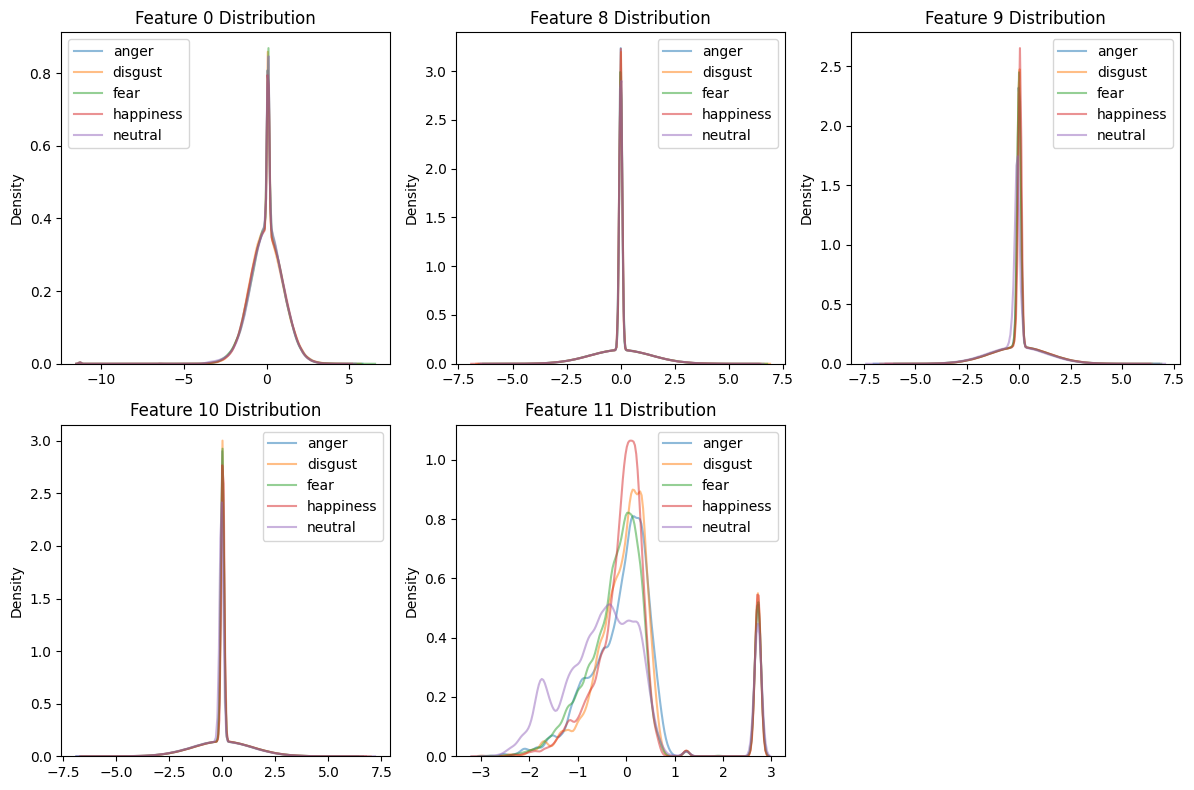

Splitting data...
Train: 22464, Val: 5616, Test: 7020


In [9]:
print("Loading data...")
try:
    data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION, SELECTED_EMOTIONS)
    print(f"Loaded {len(data_list)} files, {len(emotion_names)} emotions: {emotion_names}")
    for i, (data, label) in enumerate(zip(data_list, labels)):
        print(f"Sample {i+1}: Shape {data.shape}, Emotion {emotion_names[label]}")
except ValueError as e:
    print(f"Data loading failed: {e}")
    raise

print("Preprocessing data...")
try:
    segments, segment_labels, scaler = preprocess_data(data_list, labels, SEGMENT_LENGTH)
except ValueError as e:
    print(f"Preprocessing failed: {e}")
    raise

print("Visualizing feature distributions...")
plot_feature_distributions(segments, segment_labels, emotion_names)

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

## validate TCN model 

In [13]:
print("Validating TCN model...")
y_pred = np.argmax(tcn_model.predict(X_test, batch_size=BATCH_SIZE), axis=1)
print(classification_report(y_test, y_pred, target_names=emotion_names))
plot_confusion_matrix(y_test, y_pred, emotion_names)

print("Generating TCN embeddings for visualization...")
embeddings = tcn_encoder.predict(X_test, batch_size=BATCH_SIZE)
plot_embeddings(embeddings, y_test, emotion_names)

Validating TCN model...


NameError: name 'X_test' is not defined

## LLM Dataset Preparation 

In [10]:
def prepare_llm_dataset(embeddings, labels, emotion_names, tokenizer, max_length=64):
    prompts, targets = [], []
    for emb, label in zip(embeddings, labels):
        emb_str = ",".join([f"{x:.4f}" for x in emb[:8]])
        prompt = f"Based on EMG signal features [{emb_str}], the emotion is:"
        target = f"The user is experiencing {emotion_names[label]}."
        prompts.append(prompt)
        targets.append(target)
    
    encodings = tokenizer(prompts, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt")
    target_encodings = tokenizer(targets, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt")
    
    dataset = Dataset.from_dict({
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    })
    return dataset

## LLM FineTuning 

In [11]:
def fine_tune_llm(model, tokenizer, dataset, output_dir="./llm_finetuned"):
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=LLM_EPOCHS,
        per_device_train_batch_size=LLM_BATCH_SIZE,
        per_device_eval_batch_size=LLM_BATCH_SIZE,
        gradient_accumulation_steps=4,
        gradient_checkpointing=True,
        fp16=True,
        learning_rate=2e-5,
        logging_steps=10,
        save_steps=100,
        save_total_limit=2,
        eval_strategy="steps",
        eval_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="loss"
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=dataset.select(range(int(0.2 * len(dataset)))),
    )
    
    trainer.train()
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

## Hybrid Model Inference

In [17]:
print("Loading LLM...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=None,
    load_in_4bit=True
)
model = FastLanguageModel.for_training(model)

print("Generating TCN embeddings for LLM training...")
train_embeddings = tcn_encoder.predict(X_train, batch_size=BATCH_SIZE)

print("Preparing LLM dataset...")
llm_dataset = prepare_llm_dataset(train_embeddings, y_train, emotion_names, tokenizer)
print(f"LLM dataset size: {len(llm_dataset)}")

print("Fine-tuning LLM...")
try:
    fine_tune_llm(model, tokenizer, llm_dataset)
except Exception as e:
    print(f"LLM fine-tuning failed: {e}")
    raise

# Hybrid inference
print("Generating sample hybrid outputs...")
FastLanguageModel.for_inference(model)
sample_indices = np.random.choice(len(X_test), 5, replace=False)
sample_segments = X_test[sample_indices]
sample_embeddings = tcn_encoder.predict(sample_segments, batch_size=BATCH_SIZE)
sample_labels = y_test[sample_indices]
tcn_predictions = np.argmax(tcn_model.predict(sample_segments, batch_size=BATCH_SIZE), axis=1)

for i, (emb, tcn_pred, true_label) in enumerate(zip(sample_embeddings, tcn_predictions, sample_labels)):
    emb_str = ",".join([f"{x:.4f}" for x in emb[:8]])
    prompt = f"Based on EMG signal features [{emb_str}], the emotion is:"
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=20)
    print(f"Sample {i+1}:")
    print(f"TCN Prediction: {emotion_names[tcn_pred]}")
    print(f"True Label: {emotion_names[true_label]}")
    print(f"LLM Output: {tokenizer.decode(outputs[0], skip_special_tokens=True)}")

Loading LLM...
==((====))==  Unsloth 2025.6.12: Fast Llama patching. Transformers: 4.53.0.
   \\   /|    NVIDIA GeForce RTX 3050 Laptop GPU. Num GPUs = 1. Max memory: 4.0 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


ValueError: Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch the model on the CPU or the disk while keeping these modules in 32-bit, you need to set `llm_int8_enable_fp32_cpu_offload=True` and pass a custom `device_map` to `from_pretrained`. Check https://huggingface.co/docs/transformers/main/en/main_classes/quantization#offload-between-cpu-and-gpu for more details. 

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Layer, Softmax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.fft import fft
import torch
from unsloth import FastLanguageModel
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from tcn import TCN

# Configuration
DATA_ROOT = "/home/saihan/New folder/data"
SELECTED_EMOTIONS = ['anger', 'disgust', 'fear', 'happiness', 'neutral']
FILES_PER_EMOTION = 10
SEGMENT_LENGTH = 128
EMBEDDING_DIM = 256
BATCH_SIZE = 16
LLM_BATCH_SIZE = 4
LLM_EPOCHS = 2
NUM_FEATURES = 12  # 8 raw + 3 time-domain + 1 frequency-domain
AUGMENT_NOISE_STD = 0.01
MIN_TIME_STEPS = 45000
MAX_SEQ_LENGTH = 2048

# Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        pt = tf.where(y_true_one_hot == 1, y_pred, 1 - y_pred)
        loss = -alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fn

# Attention Layer
class AttentionLayer(Layer):
    def __init__(self, trainable=True, dtype='float32', **kwargs):
        super(AttentionLayer, self).__init__(trainable=trainable, dtype=dtype, **kwargs)

    def build(self, input_shape):
        self.dense = Dense(1, activation='tanh')
        self.softmax = Softmax(axis=1)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        attention = self.dense(inputs)
        attention = self.softmax(attention)
        weighted = inputs * attention
        return tf.reduce_sum(weighted, axis=1)

    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Feature Extraction
def extract_features(segments):
    segments = (segments - np.mean(segments, axis=1, keepdims=True)) / (np.std(segments, axis=1, keepdims=True) + 1e-8)
    mean = np.mean(segments, axis=(1, 2), keepdims=True)
    variance = np.var(segments, axis=(1, 2), keepdims=True)
    rms = np.sqrt(np.mean(segments**2, axis=(1, 2), keepdims=True))
    freq = np.abs(fft(segments, axis=1))[:, :SEGMENT_LENGTH//2]
    mean_freq = np.mean(freq, axis=(1, 2), keepdims=True)
    mean = np.repeat(np.repeat(mean, SEGMENT_LENGTH, axis=1), 1, axis=2)
    variance = np.repeat(np.repeat(variance, SEGMENT_LENGTH, axis=1), 1, axis=2)
    rms = np.repeat(np.repeat(rms, SEGMENT_LENGTH, axis=1), 1, axis=2)
    mean_freq = np.repeat(np.repeat(mean_freq, SEGMENT_LENGTH, axis=1), 1, axis=2)
    return np.concatenate([segments, mean, variance, rms, mean_freq], axis=2)

# Data Loading
def load_emotion_data(data_root, files_per_emotion, selected_emotions):
    data, labels, emotion_names = [], [], []
    emotion_dirs = sorted([d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d)) and d in selected_emotions])
    
    for idx, emotion in enumerate(emotion_dirs):
        emotion_path = os.path.join(data_root, emotion)
        emotion_data = []
        for i in range(1, files_per_emotion + 1):
            file_path = os.path.join(emotion_path, f"{emotion}_{i}.npy")
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            try:
                emg = np.load(file_path)
                if emg.shape[1] == 8 and emg.shape[0] >= SEGMENT_LENGTH:
                    if emg.shape[0] > MIN_TIME_STEPS:
                        emg = emg[:MIN_TIME_STEPS]
                    elif emg.shape[0] < MIN_TIME_STEPS:
                        emg = np.pad(emg, ((0, MIN_TIME_STEPS - emg.shape[0]), (0, 0)), mode='constant')
                    emotion_data.append(emg)
                    print(f"Loaded {file_path}: Shape {emg.shape}")
                else:
                    print(f"Invalid shape or length in {file_path}: {emg.shape}")
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
        
        if emotion_data:
            data.extend(emotion_data)
            labels.extend([idx] * len(emotion_data))
            emotion_names.append(emotion)
        else:
            print(f"No valid data for emotion: {emotion}")
    
    if not data:
        raise ValueError("No valid data loaded!")
    return data, labels, emotion_names

# Data Preprocessing
def preprocess_data(data_list, labels, segment_length):
    segments, segment_labels = [], []
    for data, label in zip(data_list, labels):
        n_segments = data.shape[0] // segment_length
        if n_segments == 0:
            print(f"Skipping sample with length {data.shape[0]} < {segment_length}")
            continue
        reshaped = data[:n_segments * segment_length].reshape(n_segments, segment_length, 8)
        print(f"Sample shape after reshape: {reshaped.shape}")
        segment_data = extract_features(reshaped)
        print(f"Sample shape after feature extraction: {segment_data.shape}")
        noise = np.random.normal(0, AUGMENT_NOISE_STD, segment_data.shape)
        segments.append(segment_data + noise)
        segments.append(segment_data)
        segment_labels.extend([label] * n_segments * 2)
    
    if not segments:
        raise ValueError("No segments created!")
    
    segments = np.concatenate(segments, axis=0)
    print(f"Concatenated segments shape: {segments.shape}")
    scaler = StandardScaler()
    reshaped = segments.reshape(-1, NUM_FEATURES)
    print(f"Flattened shape for scaling: {reshaped.shape}")
    scaled = scaler.fit_transform(reshaped)
    segments = scaled.reshape(segments.shape[0], segment_length, NUM_FEATURES)
    print(f"Final preprocessed shape: {segments.shape}")
    unique, counts = np.unique(segment_labels, return_counts=True)
    print("Segments per class:", dict(zip([SELECTED_EMOTIONS[i] for i in unique], counts)))
    return segments, np.array(segment_labels), scaler

# LLM Dataset Preparation
def prepare_llm_dataset(embeddings, labels, emotion_names, tokenizer, max_length=64):
    prompts, targets = [], []
    for emb, label in zip(embeddings, labels):
        emb_str = ",".join([f"{x:.4f}" for x in emb[:8]])
        prompt = f"Based on EMG signal features [{emb_str}], the emotion is:"
        target = f"The user is experiencing {emotion_names[label]}."
        prompts.append(prompt)
        targets.append(target)
    
    encodings = tokenizer(prompts, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt")
    target_encodings = tokenizer(targets, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt")
    
    dataset = Dataset.from_dict({
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"],
        "labels": target_encodings["input_ids"]
    })
    return dataset

# LLM Fine-Tuning
def fine_tune_llm(model, tokenizer, dataset, output_dir="./llm_finetuned"):
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=LLM_EPOCHS,
        per_device_train_batch_size=LLM_BATCH_SIZE,
        per_device_eval_batch_size=LLM_BATCH_SIZE,
        gradient_accumulation_steps=4,
        gradient_checkpointing=True,
        fp16=True,
        learning_rate=2e-5,
        logging_steps=10,
        save_steps=100,
        save_total_limit=2,
        eval_strategy="steps",
        eval_steps=50,
        load_best_model_at_end=True,
        metric_for_best_model="loss"
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=dataset.select(range(int(0.2 * len(dataset)))),
    )
    
    trainer.train()
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

# Main Execution
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("CUDA_VISIBLE_DEVICES:", os.environ.get('CUDA_VISIBLE_DEVICES', 'Not set'))
print("PyTorch CUDA available:", torch.cuda.is_available())

print("Loading TCN model...")
try:
    tcn_model = load_model("emotion_tcn_model.keras", custom_objects={"TCN": TCN, "AttentionLayer": AttentionLayer, "focal_loss_fn": focal_loss(gamma=2.0, alpha=0.25)})
    print("Model layers:", [layer.name for layer in tcn_model.layers])
    try:
        tcn_encoder = Model(inputs=tcn_model.input, outputs=tcn_model.get_layer("segment_embedding").output)
        print("TCN encoder extracted successfully.")
    except ValueError as e:
        print(f"Error: 'segment_embedding' layer not found. Available layers: {[layer.name for layer in tcn_model.layers]}")
        raise
except Exception as e:
    print(f"Failed to load TCN model: {e}")
    raise

print("Loading data...")
try:
    data_list, labels, emotion_names = load_emotion_data(DATA_ROOT, FILES_PER_EMOTION, SELECTED_EMOTIONS)
    print(f"Loaded {len(data_list)} files, {len(emotion_names)} emotions: {emotion_names}")
except ValueError as e:
    print(f"Data loading failed: {e}")
    raise

print("Preprocessing data...")
try:
    segments, segment_labels, scaler = preprocess_data(data_list, labels, SEGMENT_LENGTH)
except ValueError as e:
    print(f"Preprocessing failed: {e}")
    raise

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    segments, segment_labels, test_size=0.2, stratify=segment_labels, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)
print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

print("Loading LLM...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=None,
    load_in_4bit=True
)
model = FastLanguageModel.for_training(model)

print("Generating TCN embeddings for LLM training...")
train_embeddings = tcn_encoder.predict(X_train, batch_size=BATCH_SIZE)

print("Preparing LLM dataset...")
llm_dataset = prepare_llm_dataset(train_embeddings, y_train, emotion_names, tokenizer)
print(f"LLM dataset size: {len(llm_dataset)}")

print("Fine-tuning LLM...")
try:
    fine_tune_llm(model, tokenizer, llm_dataset)
except Exception as e:
    print(f"LLM fine-tuning failed: {e}")
    raise

print("Saving models...")
model.save_pretrained("./llm_finetuned")
tokenizer.save_pretrained("./llm_finetuned")
tcn_encoder.save("./tcn_encoder.keras")
tcn_model.save("./tcn_classifier.keras")

2025-07-02 23:33:05.829186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-02 23:33:06.994020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
TensorFlow version: 2.16.1
GPU available: []
CUDA_VISIBLE_DEVICES: Not set
PyTorch CUDA available: True
Loading TCN model...


2025-07-02 23:33:20.084297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-02 23:33:20.087571: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model layers: ['input_layer_1', 'tcn_2', 'batch_normalization_2', 'tcn_3', 'attention_layer', 'batch_normalization_3', 'add_1', 'dense_5', 'dropout_2', 'segment_embedding', 'dense_6', 'dropout_3', 'dense_7']
TCN encoder extracted successfully.
Loading data...
Loaded /home/saihan/New folder/data/anger/anger_1.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_2.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_3.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_4.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_5.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_6.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_7.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_8.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_9.npy: Shape (45000, 8)
Loaded /home/saihan/New folder/data/anger/anger_10.npy: Shape (45000, 8)
Loaded /home/saihan

ValueError: You cannot perform fine-tuning on purely quantized models. Please attach trainable adapters on top of the quantized model to correctly perform fine-tuning. Please see: https://huggingface.co/docs/transformers/peft for more details